In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
numpy2ri.activate()
import scanpy.api as sc
import scipy as sp
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.set_figure_params(dpi_save=300, format='pdf')
sc.settings.figdir = '../../results/figures/'

scanpy==1.3.3 anndata==0.6.10 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Read data

In [2]:
adata = sc.read('../../results/zebrafish_neurogenesis_smartseq.h5ad', backup_url='https://cloud.pks.mpg.de/index.php/s/KyQ2ysyYRqT8xpo/download')

In [3]:
adata.obs = adata.obs.rename(columns={'cell.type': 'sort_gate'})

In [4]:
adata.var_names = list(adata.var['Symbol'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.var_names_make_unique()

In [6]:
adata = adata[:, ~adata.var['is_feature_control_ERCC']]

In [7]:
adata.obs['sort_gate'].cat.reorder_categories(['RG', 'NBN', 'ON'], inplace=True)
adata.obs['sort_gate'].cat.rename_categories({'ON': 'MN'}, inplace=True)

In [8]:
adata_original = adata.copy()

## Read EGFP and Mcherry TPMs

In [9]:
tpms = pd.concat([pd.read_excel('../../data/bfx1067.tpm-values.gfp_mcherry.xlsx', index_col='Sample', 
              usecols=[0, 2, 3], sheet_name=i) for i in range(3)])
tpms = tpms.rename(columns={'Mcherry': 'mCherry'})

In [10]:
for name in tpms:
    adata.obs[name] = tpms[name]
    adata.obs[f'log_{name}'] = np.log1p(adata.obs[name])

In [11]:
facs = pd.read_excel('../../data/Valid ops_fluorescence values.xlsx', index_col='Well')
facs = facs.rename(columns={'GFP': 'EGFP_FACS', 'mcherry': 'mCherry_FACS'})

for name in facs:
    adata.obs[name] = facs[name]
    adata.obs[f'log_{name}'] = np.log1p(adata.obs[name])

/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log1p
/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log1p


# Genes of interest

In [12]:
markers = {}

# correct marker names
markers['RG'] = ['her4.1', 'cx43', 'id1', 's100b']
markers['NBN'] = ['elavl3', 'map2', 'insm1a']
markers['MN'] = ['sv2a', 'nrgna', 'camk2a']
markers['proliferation'] = ['ccnd1', 'mki67', 'mcm5']
markers['pseudotime'] = ['sox4a', 'sox4b', 'sox11a', 'insm1a', 'insm1b', 'eomesa', 'neurod1', 'neurod4',
                         'neurod6a', 'neurod6b', 'slc17a6a', 'slc17a6b', 'dlx1a', 'dlx2a', 'dlx5a', 'gad1b', 'gad2', 'emx3']

Test whether all markers are in gene list. Remove markers that are not.

In [13]:
ok = True
for key, item in markers.items():
    for marker in item:
        try:
            adata_original.var.loc[marker]
        except:
            print('Removing', key, 'marker', marker)
            item.remove(marker)
            ok = False
if ok:
    print('All markers in gene list')

All markers in gene list


In [14]:
all_markers = []
for key, markerlist in markers.items():
    for marker in markerlist:
        all_markers.append(marker)
markers['all'] = np.unique(all_markers)

In [15]:
markers['christian'] = markers['RG'] + markers['NBN'] + markers['MN']

In [16]:
print(markers['christian'])

['her4.1', 'cx43', 'id1', 's100b', 'elavl3', 'map2', 'insm1a', 'sv2a', 'nrgna', 'camk2a']


In [17]:
markers['2A'] = ['her4.1', 'cx43', 's100b', 'id1', 'elavl3', 'map2', 'insm1a', 'sv2a', 'nrgna', 'camk2a']

# Preprocessing

## Summary statistics of sequencing

In [18]:
adata.obs[['total_counts', 'total_features_by_counts']].describe()

total_counts  total_features_by_counts
count     370.000000                370.000000
mean   214541.072973               1452.670270
std    136085.806097                956.723754
min       627.000000                125.000000
25%    111523.250000                633.250000
50%    190830.500000               1407.500000
75%    319417.250000               2035.750000
max    571547.000000               9066.000000

## Quality Control

Number of cells before QC:

In [19]:
print(f'Total number of cells before QC: {adata.n_obs}')
print('Distribution on sorts:')
sorts_before = adata.obs.groupby('sort_gate').size()
print(sorts_before)

Total number of cells before QC: 370
Distribution on sorts:
sort_gate
RG     171
NBN    169
MN      30
dtype: int64


In [20]:
min_log10_counts = 4.5
min_log10_features = 2.7
max_log10_features = 3.9
max_Mito = 20
max_ERCC=25
min_mapped = 0.2
max_pct_counts_top50 = 50

n_cells0 = adata.n_obs

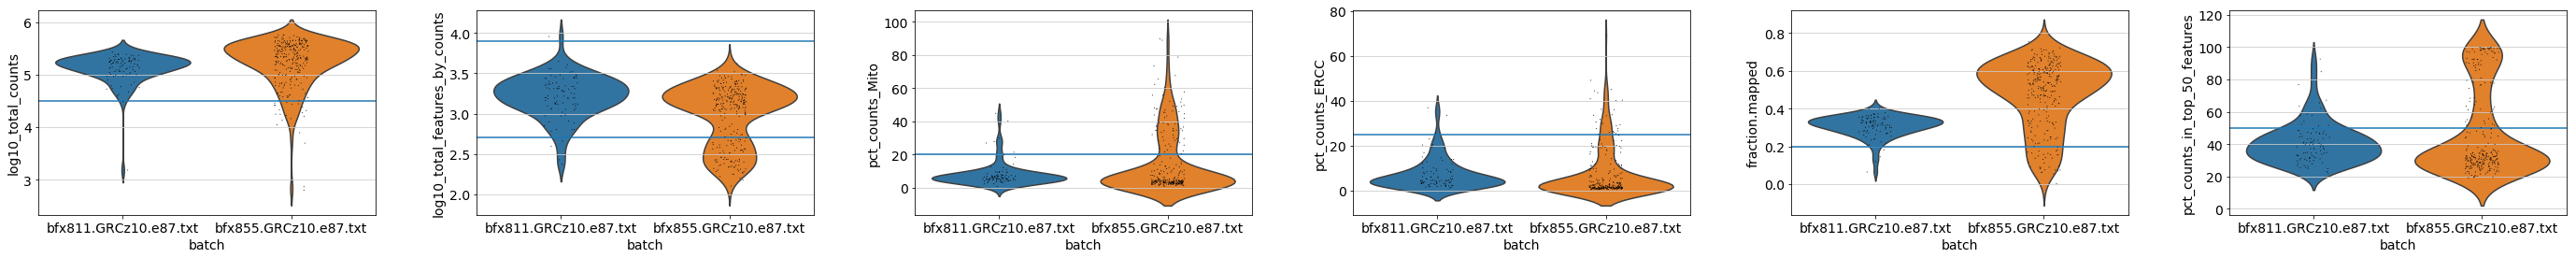

In [21]:
axs = sc.pl.violin(adata, 
             ['log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped', 'pct_counts_in_top_50_features'], 
             groupby='batch', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[1].axhline(max_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
axs[4].axhline(min_mapped)
axs[5].axhline(max_pct_counts_top50)
plt.show()

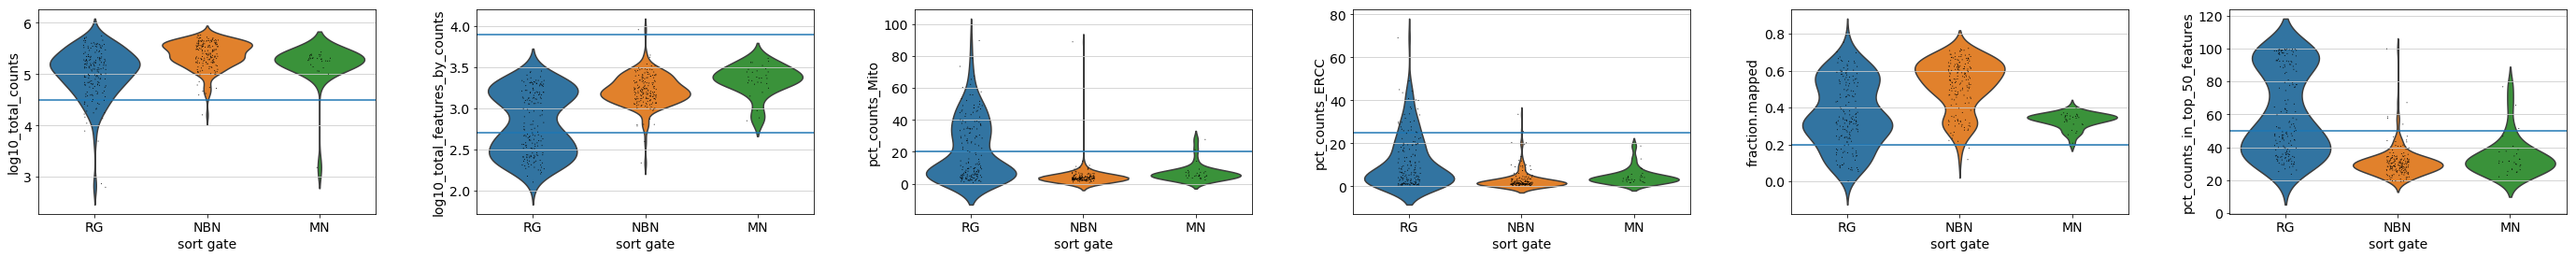

In [22]:
axs = sc.pl.violin(adata, 
             ['log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped', 'pct_counts_in_top_50_features'], 
             groupby='sort_gate', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[1].axhline(max_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
axs[4].axhline(min_mapped)
axs[5].axhline(max_pct_counts_top50)
plt.show()

In [23]:
adata = adata[adata.obs['log10_total_counts'] > min_log10_counts]
adata = adata[adata.obs['log10_total_features_by_counts'] > min_log10_features]
adata = adata[adata.obs['log10_total_features_by_counts'] < max_log10_features]
adata = adata[adata.obs['pct_counts_Mito'] < max_Mito]
adata = adata[adata.obs['pct_counts_ERCC'] < max_ERCC]
adata = adata[adata.obs['fraction.mapped'] > min_mapped]
adata = adata[adata.obs['pct_counts_in_top_50_features'] < max_pct_counts_top50]
print(f'Filtered {n_cells0 - adata.n_obs} cells. Remaining cells: {adata.n_obs}')

Filtered 106 cells. Remaining cells: 264


In [24]:
adata.obs.groupby('sort_gate').size()

sort_gate
RG      76
NBN    162
MN      26
dtype: int64

In [25]:
df1 = pd.DataFrame(sorts_before, columns=['cells']).reset_index()
df1['when'] = 'before QC'
df2 = pd.DataFrame(adata.obs.groupby('sort_gate').size(), columns=['cells']).reset_index()
df2['when'] = 'after QC'
df = pd.concat([df1, df2])
df

sort_gate  cells       when
0        RG    171  before QC
1       NBN    169  before QC
2        MN     30  before QC
0        RG     76   after QC
1       NBN    162   after QC
2        MN     26   after QC

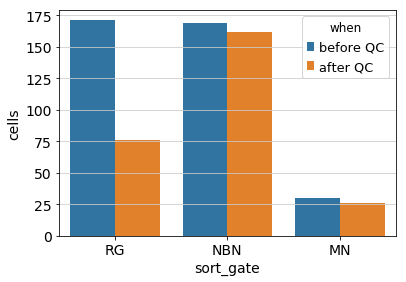

In [26]:
sns.barplot(data=df, x='sort_gate', y='cells', hue='when')
plt.show()

## HVGs

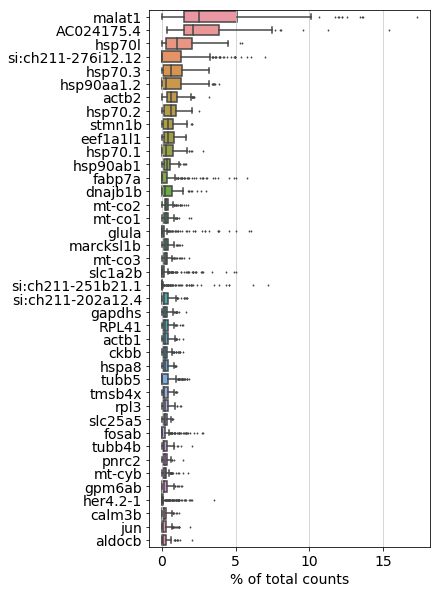

In [27]:
sc.pl.highest_expr_genes(adata, n_top=40)

In [28]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14960 genes that are detected in less than 3 cells


In [29]:
sc.pp.log1p(adata)

In [30]:
sc.pp.highly_variable_genes(adata, max_mean=8.0)

In [31]:
print(f'HVGs: {adata.var["highly_variable"].sum()}')

HVGs: 5142


In [32]:
# sc.pl.highly_variable_genes(adata)

## Normalization

### Library Size

Perform this to set the normalisation flag:

In [33]:
# sc.pp.normalize_per_cell(adata)
# sc.pp.log1p(adata)

### Scran

Use all "detectable" genes for normalisation.

In [34]:
adata_scran = adata_original[adata.obs_names].copy()

In [35]:
sc.pp.filter_genes(adata_scran, min_cells=3)

filtered out 14960 genes that are detected in less than 3 cells


In [36]:
robjects.globalenv['counts'] = adata_scran.X.T.toarray()
adata.obs['sizeFactor'] = robjects.r(
    """
    suppressPackageStartupMessages(library(scater))
    suppressPackageStartupMessages(library(scran))
    clusters <- quickCluster(counts, method="igraph", min.mean=1.0,
    irlba.args=list(maxit=1000))
    computeSumFactors(counts, min.mean=1.0, cluster=clusters)
    """)

In [37]:
adata.obs['log10_sizeFactor'] = np.log10(adata.obs['sizeFactor'])

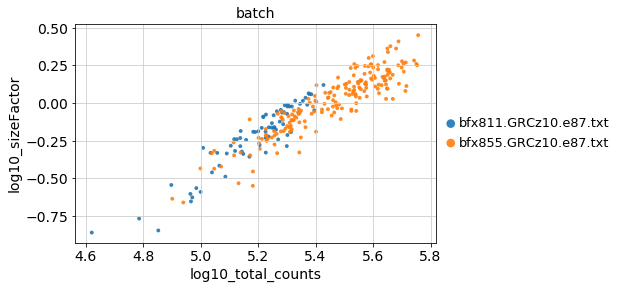

In [38]:
sc.pl.scatter(adata, x='log10_total_counts', y='log10_sizeFactor', size=60, alpha=0.9,
             color='batch')

In [39]:
adata.X = sp.sparse.csr_matrix(adata_original[adata.obs_names][:, adata.var_names].X.T 
                     / adata.obs['sizeFactor'].values.astype(np.float32)
                    ).T

In [40]:
sc.pp.log1p(adata)

## Scale

In [41]:
sc.pp.scale(adata)

## Store raw data

In [42]:
adata.raw = sc.pp.log1p(adata_original[adata.obs_names], copy=True)


# Fig. 2A

In [43]:
sc.set_figure_params(dpi=80, format='pdf')

In [44]:
plot_data = adata.obs[['sort_gate']].copy()

In [45]:
for marker in markers['2A']:
    plot_data[marker] = np.log(adata_original[plot_data.index][:, marker].X.copy() + 1)

In [46]:
# plot_data.loc[:,'her4.1':] = plot_data.loc[:,'her4.1':] / plot_data.loc[:,'her4.1':].max()

In [47]:
# with sns.color_palette('Set2'):
#     fig, axs = plt.subplots(3, 4, sharex=False, sharey=True, figsize=(3.1,6.5))
#     for gene, ax in zip(markers['2A'][:4], axs[0]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     for gene, ax in zip(markers['2A'][4:7], axs[1][:3]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     for gene, ax in zip(markers['2A'][7:10], axs[2][:3]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     axs[0,0].set_ylabel('Log reads')
#     axs[1,0].set_ylabel('Log reads')
#     axs[2,0].set_ylabel('Log reads')
#     axs[1,3].remove()
#     axs[2,3].remove()
#     ax.set_ylim(-1.9, None)
#     plt.tight_layout(0, 2, 0)
#     plt.savefig('../../results/figures/stacked_violin_2A.pdf', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()

# PCA

In [48]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

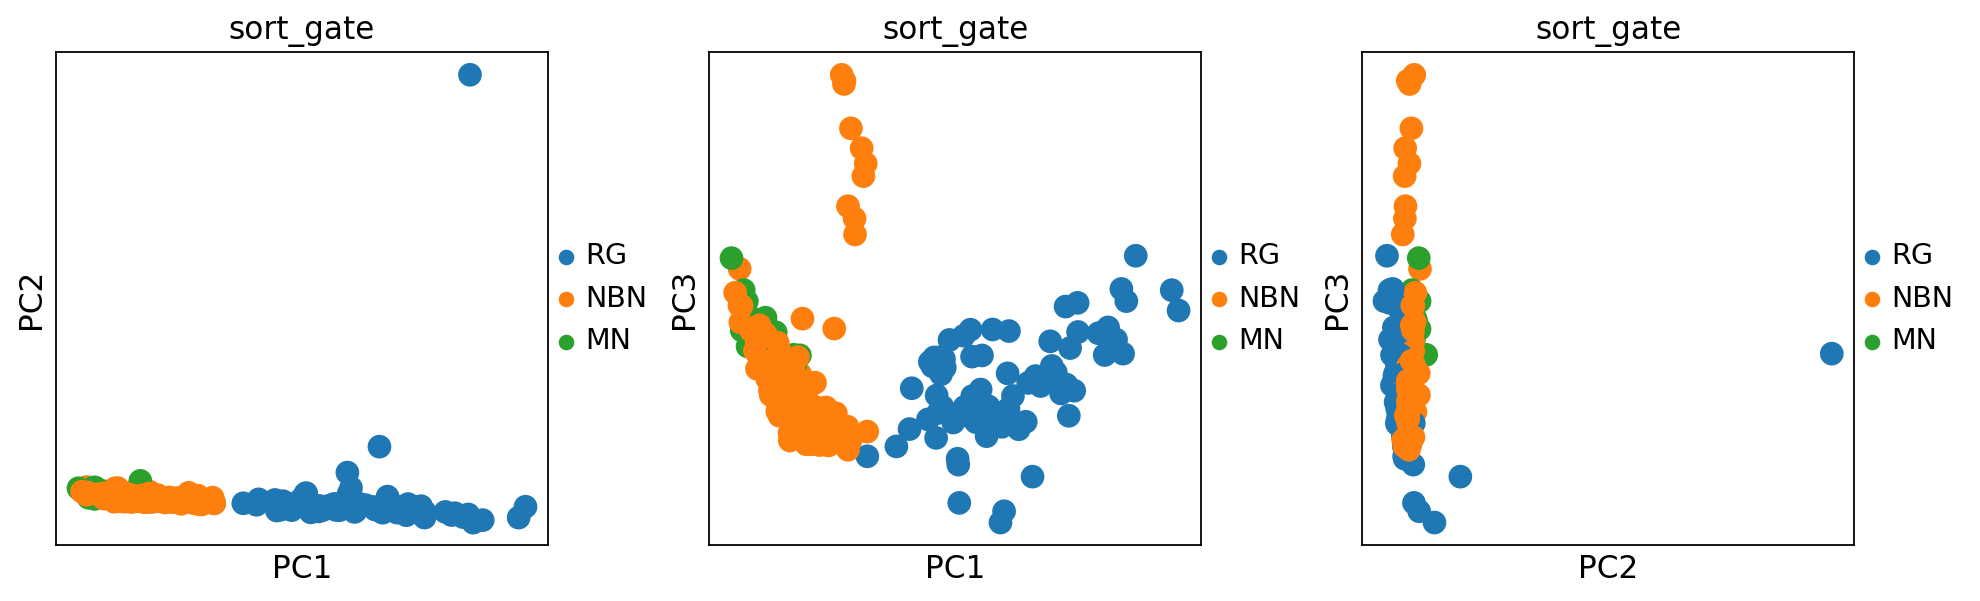

In [49]:
sc.pl.pca(adata, components=['1,2', '1,3', '2,3'], color='sort_gate')

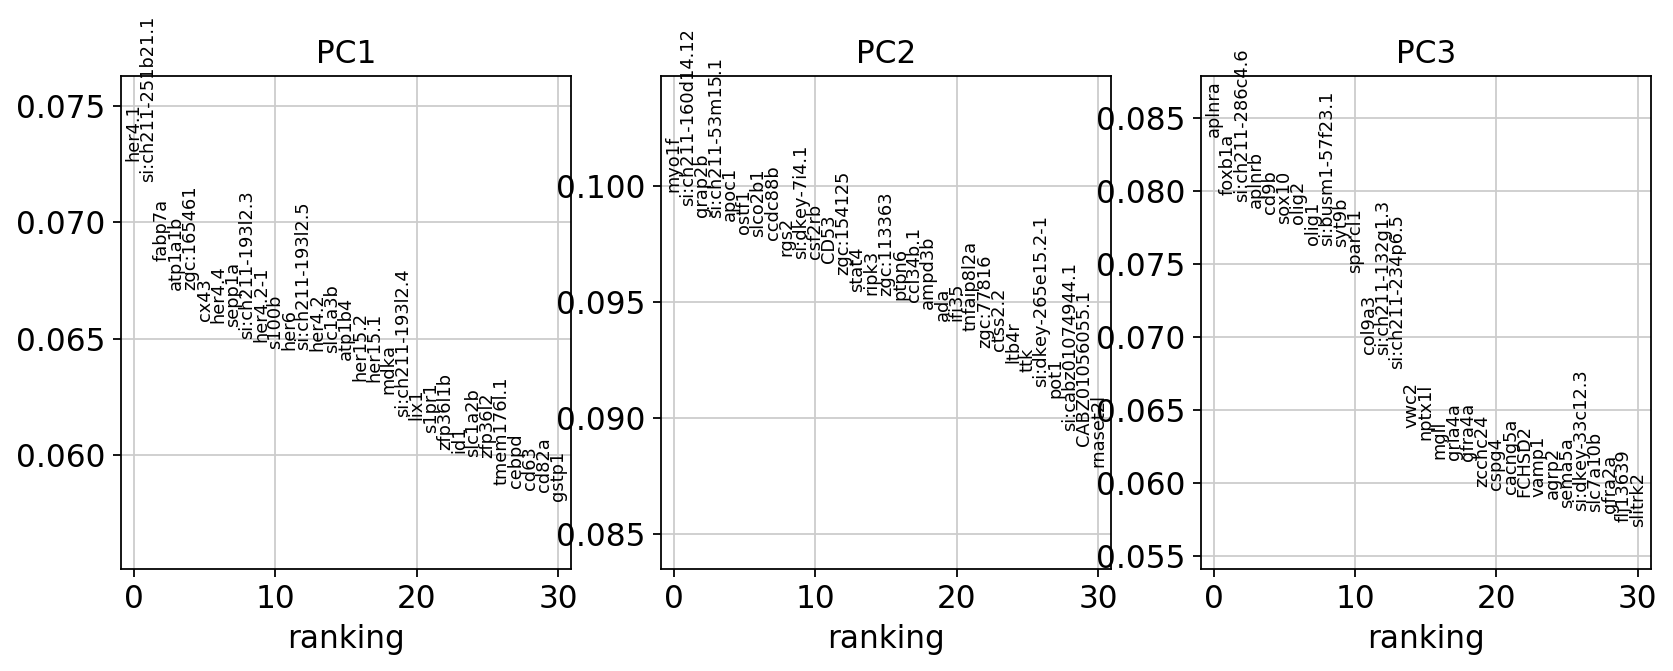

In [50]:
sc.pl.pca_loadings(adata)

In [51]:
genes_PC2 = adata.var.iloc[adata.varm['PCs'][:,1].argsort()[::-1]].index[:4]

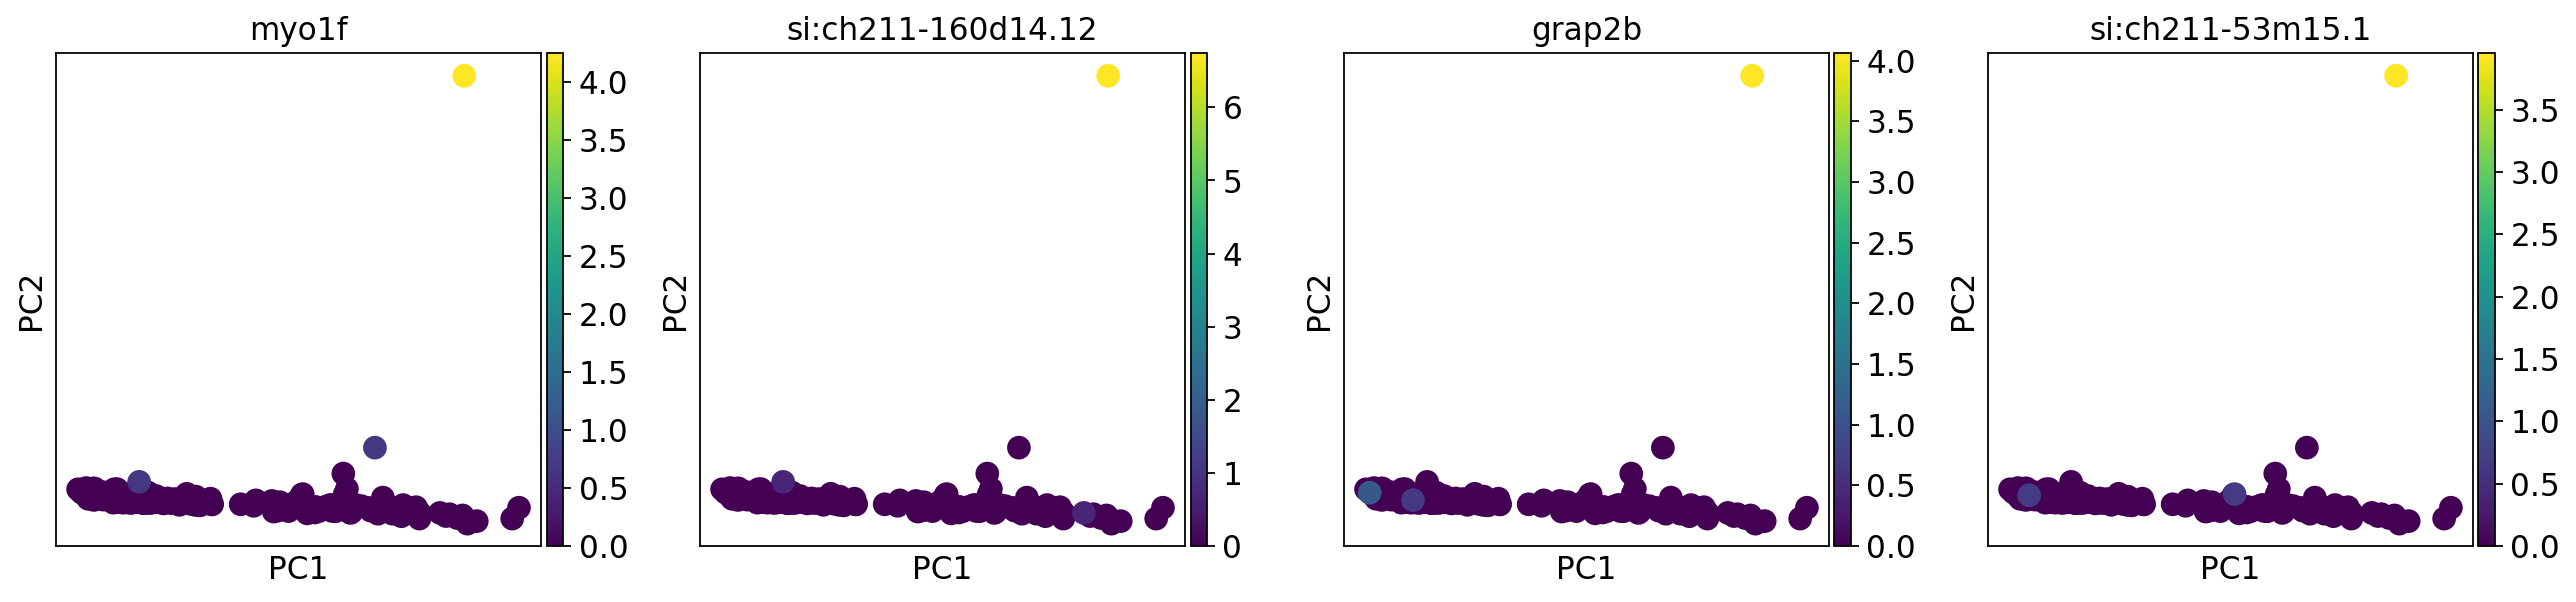

In [52]:
sc.pl.pca(adata, color=genes_PC2)

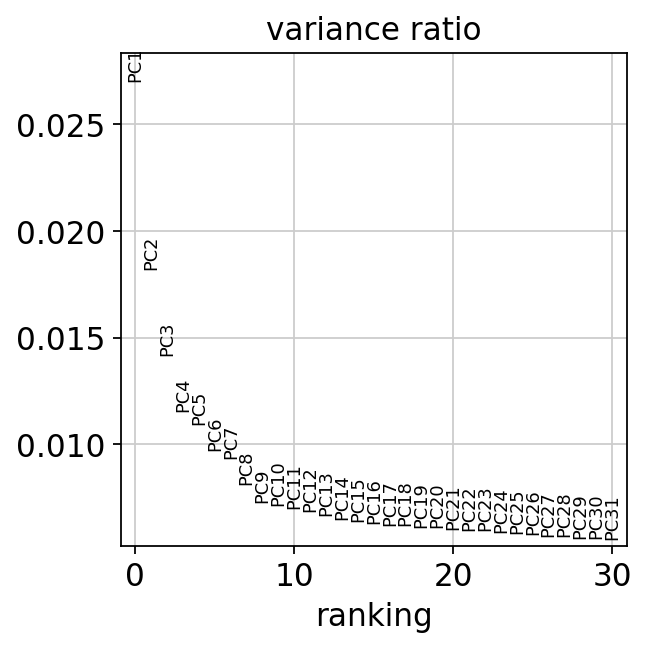

In [53]:
sc.pl.pca_variance_ratio(adata)

In [54]:
adata.uns['pca']['variance_ratio'][:15].sum()

0.15656213

## Quality on PCA:

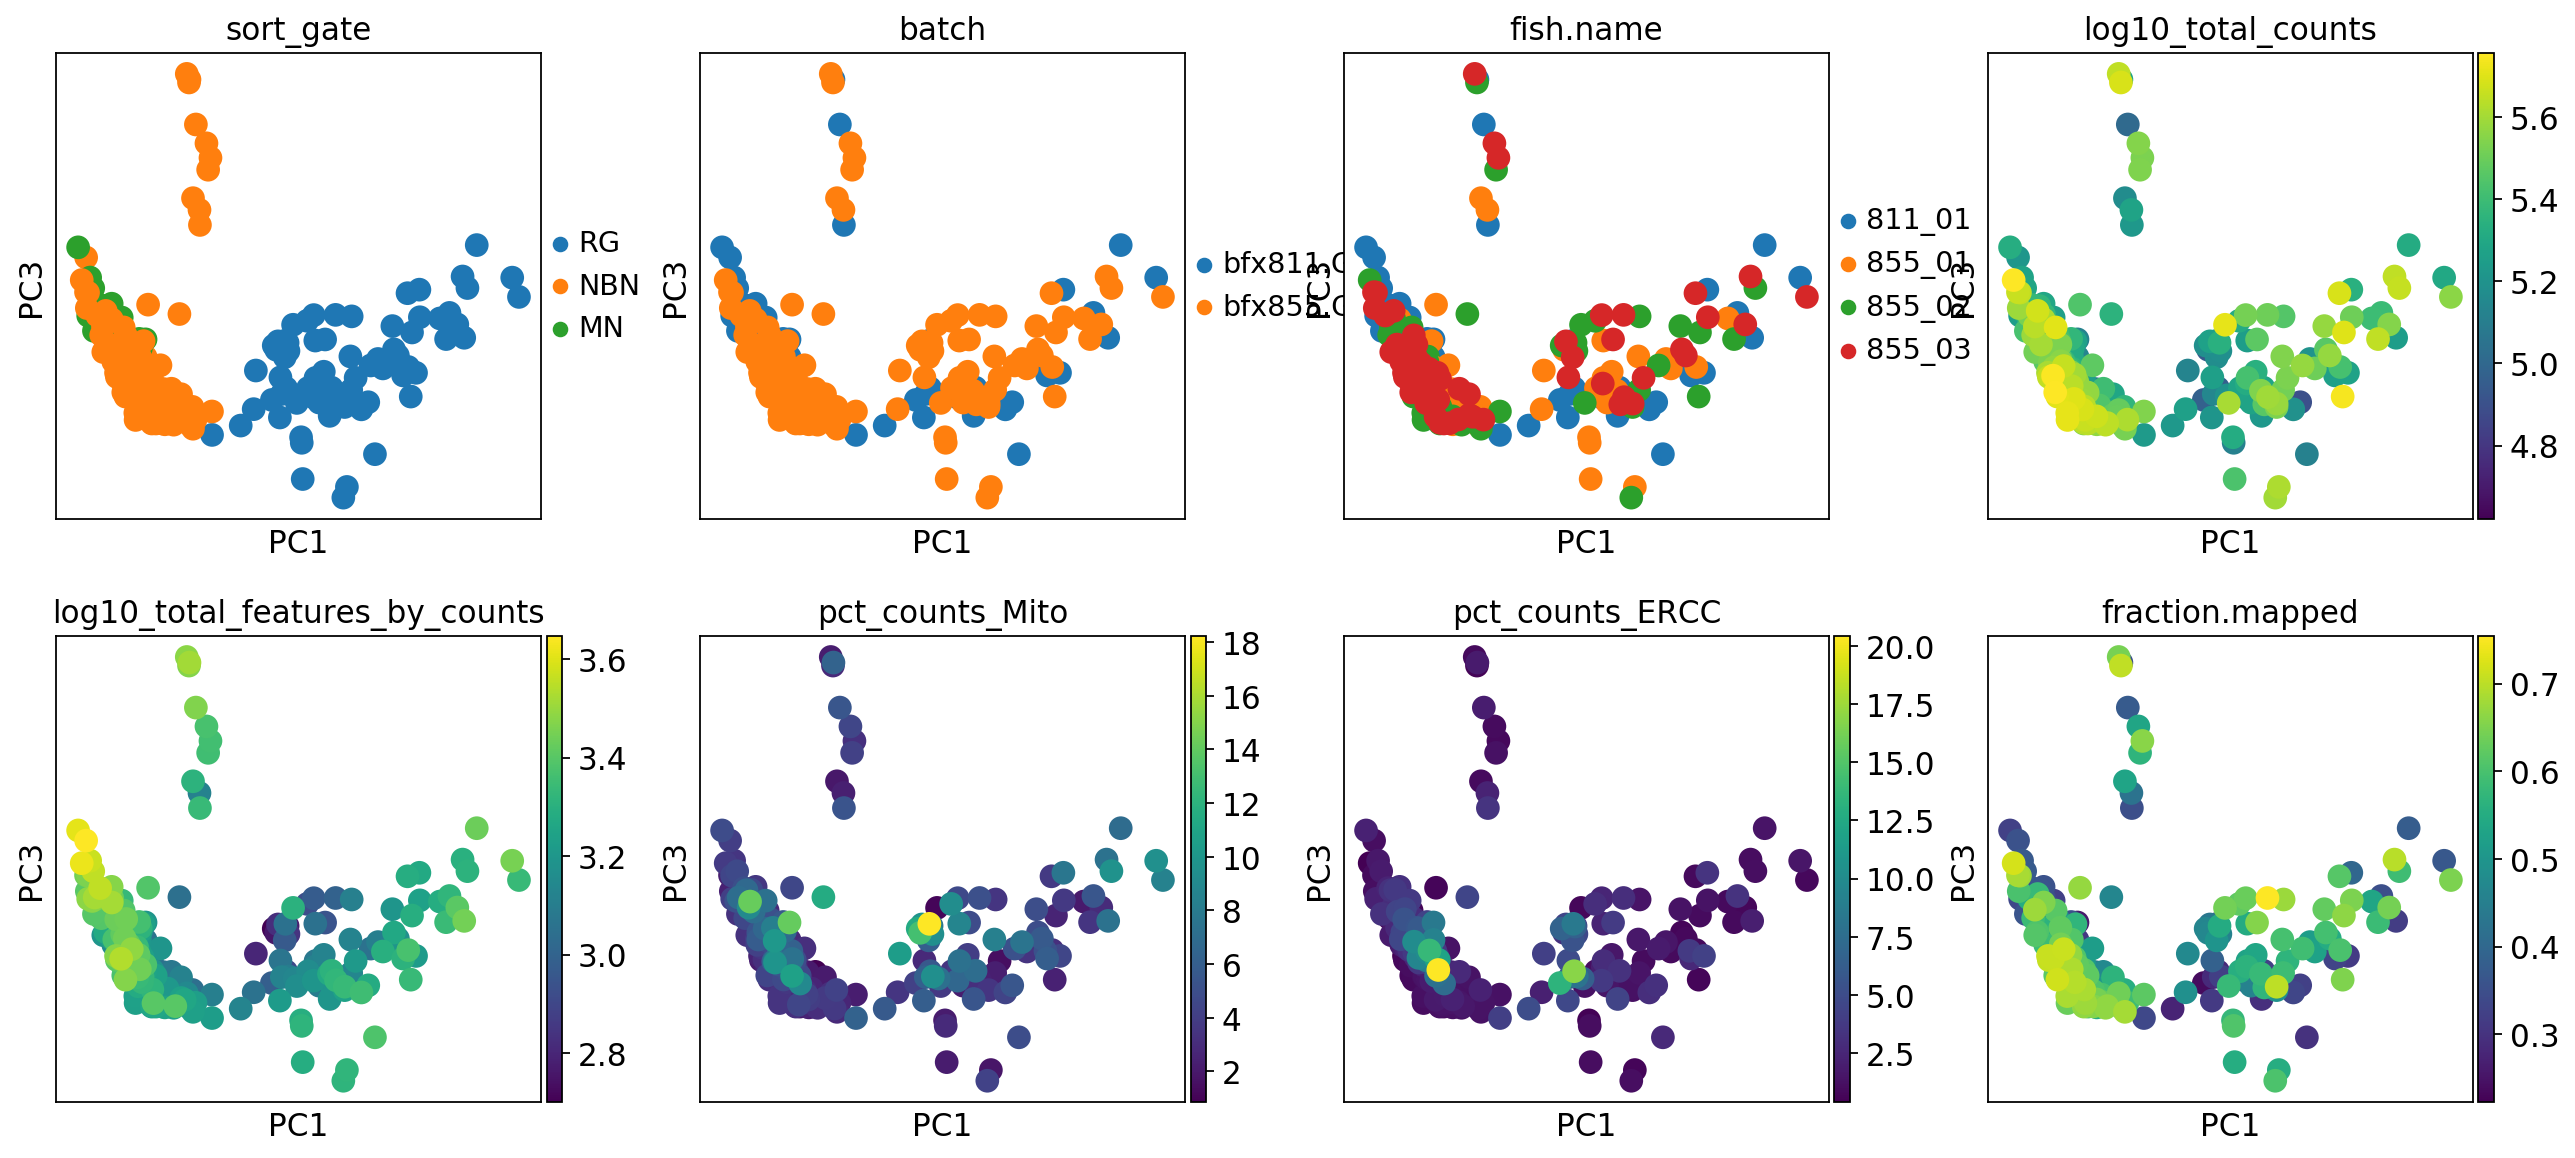

In [55]:
# sc.pl.pca(adata, color=['sort_gate', 'batch', 'fish.name', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
#               'pct_counts_ERCC', 'fraction.mapped'], components=['1,2'])
sc.pl.pca(adata, color=['sort_gate', 'batch', 'fish.name', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped'], components=['1,3'])

# tsnE

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:01.04) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.97) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


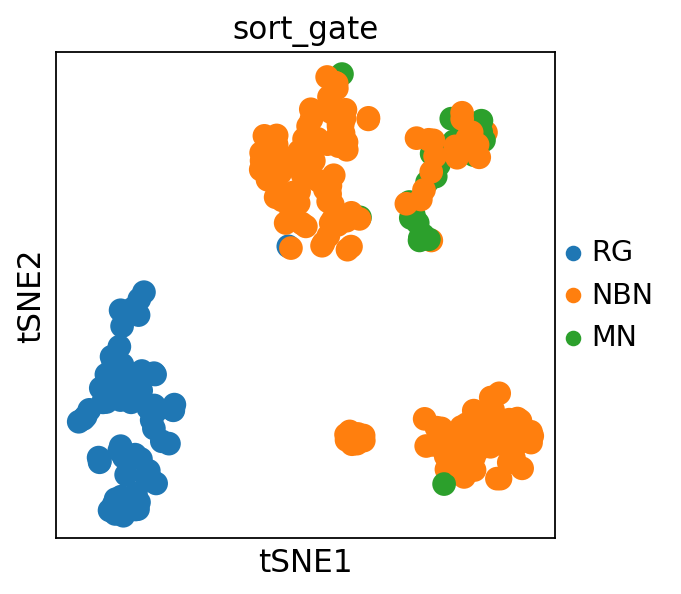

In [56]:
sc.tl.tsne(adata, n_pcs=10, random_state=1, n_jobs=10, perplexity=15)
sc.tl.tsne(adata, n_pcs=10, random_state=1, n_jobs=10, perplexity=15)
sc.pl.tsne(adata, color='sort_gate')

# UMAP

computing neighbors
    using 'X_pca' with n_pcs = 10


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03.17) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)


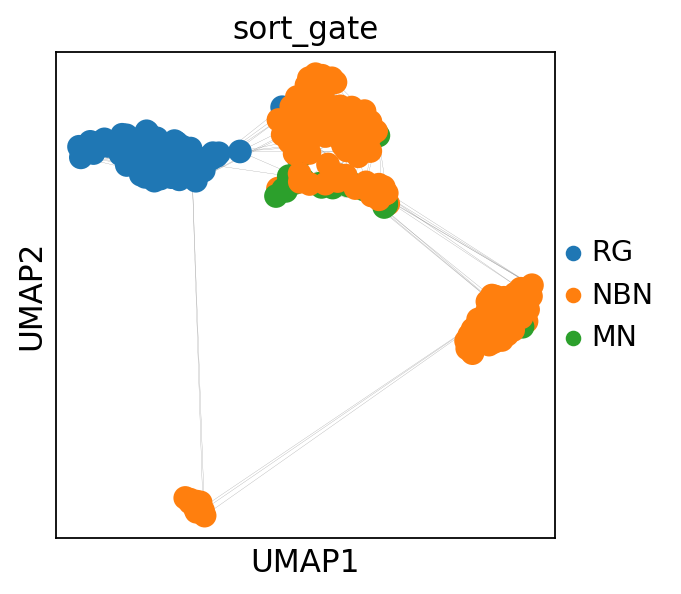

In [57]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color='sort_gate', edges=True)

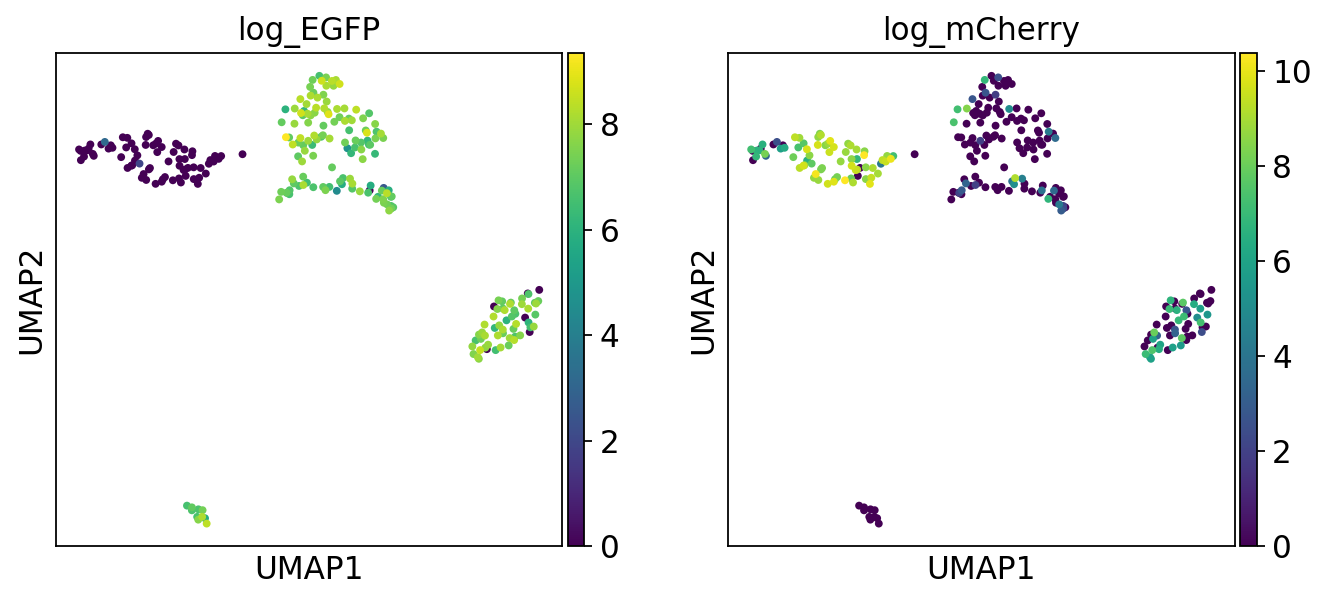

In [58]:
sc.pl.umap(adata, color=['log_EGFP', 'log_mCherry'], size=50)

# Diffusion Map

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.0000001  0.99110854 0.98986876 0.98613155 0.97614384 0.9715326
     0.95523995 0.9369764  0.9229472  0.91546625 0.91148317 0.90654314
     0.9023228  0.8862993  0.86983746]
    finished (0:00:00.02) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


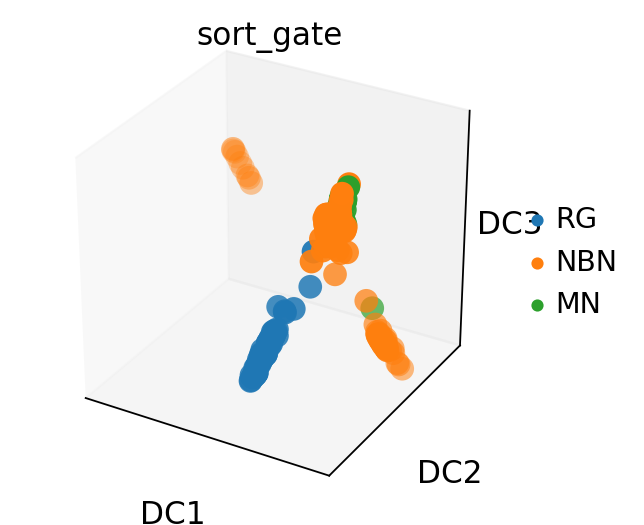

In [59]:
# sc.pp.neighbors(adata, n_neighbors=80, n_pcs=10)
sc.pp.neighbors(adata, method='gauss', knn=False, n_neighbors=5, n_pcs=10, random_state=21)
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color='sort_gate', projection='3d')
# sc.pl.diffmap(adata, color='louvain', components=['1,2', '1,3', '2,3'])
plt.show()

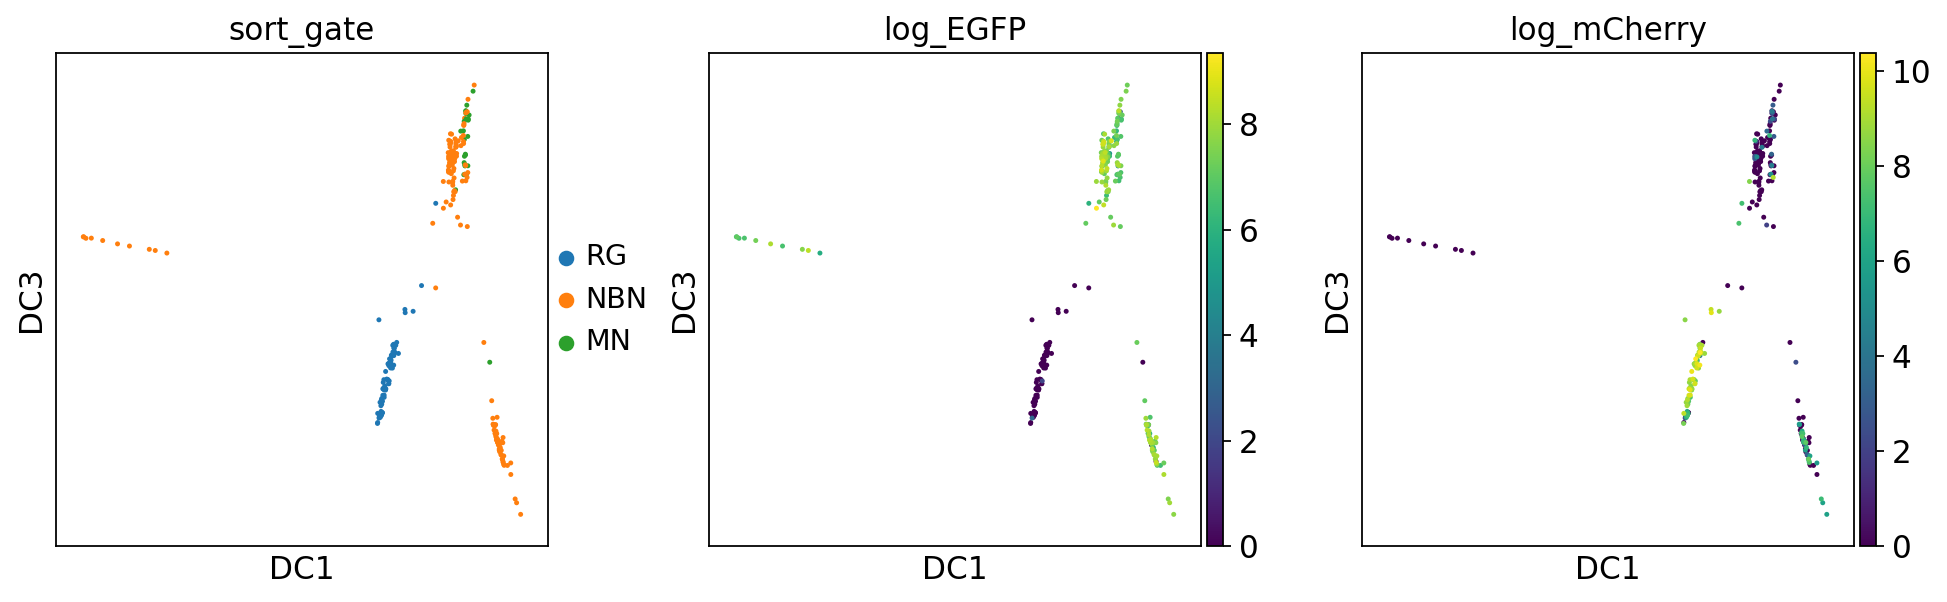

In [60]:
sc.pl.diffmap(adata, color=['sort_gate', 'log_EGFP', 'log_mCherry'], components=['1,3'], size=20)

# Clustering

In [61]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.louvain(adata, resolution=0.5, random_state=1)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


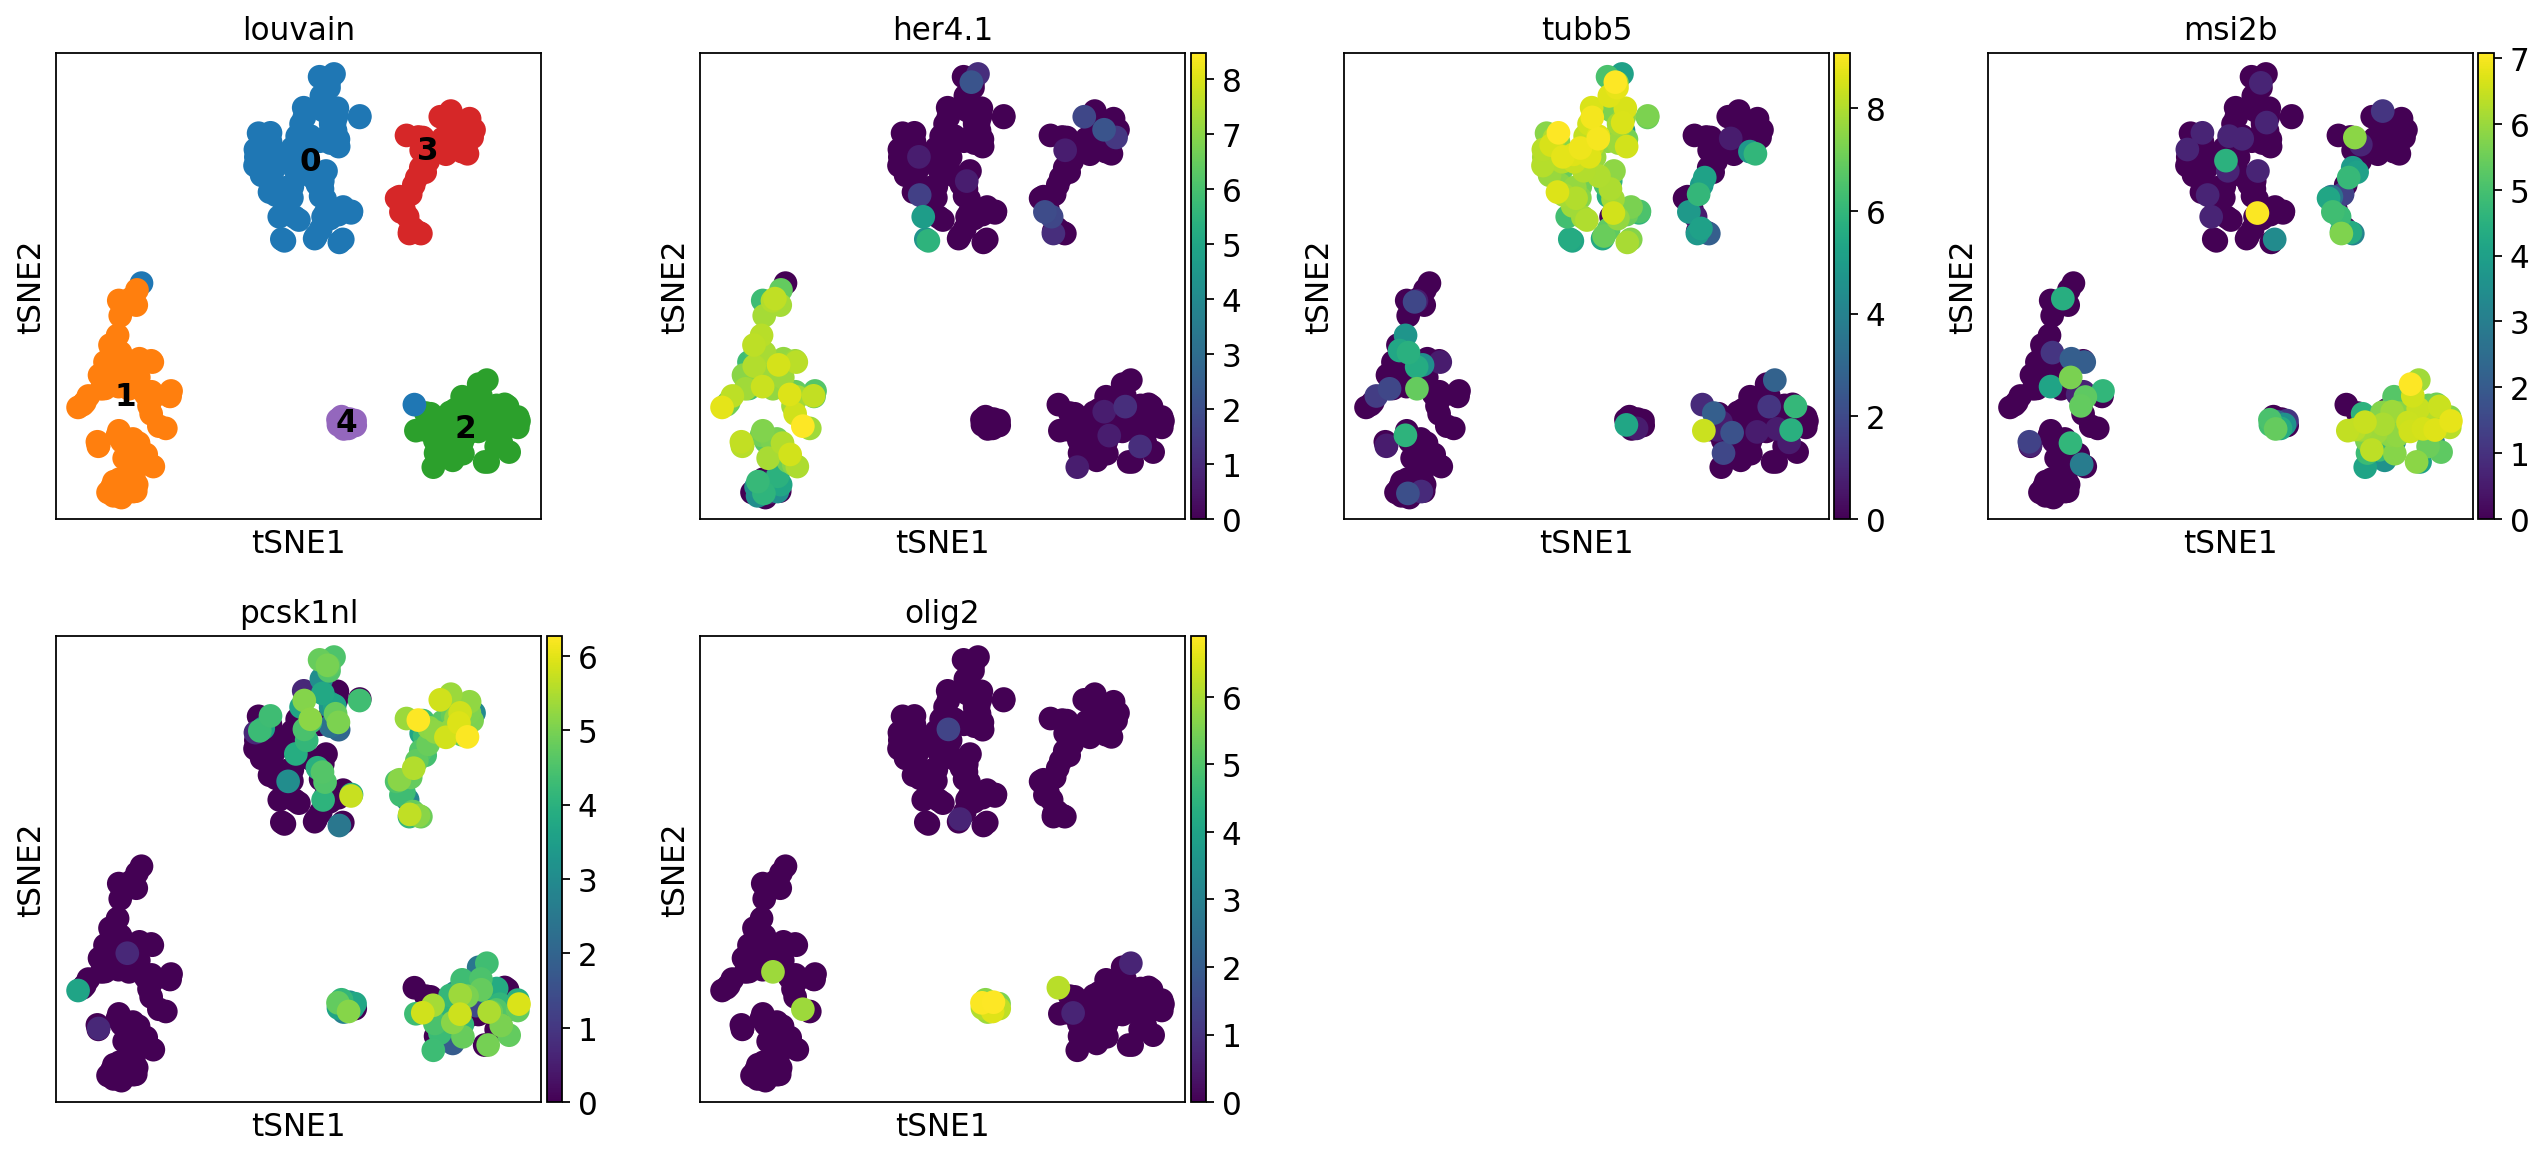

In [62]:
sc.pl.tsne(adata, color=['louvain', 'her4.1', 'tubb5', 'msi2b', 'pcsk1nl', 'olig2'], legend_loc='on data')

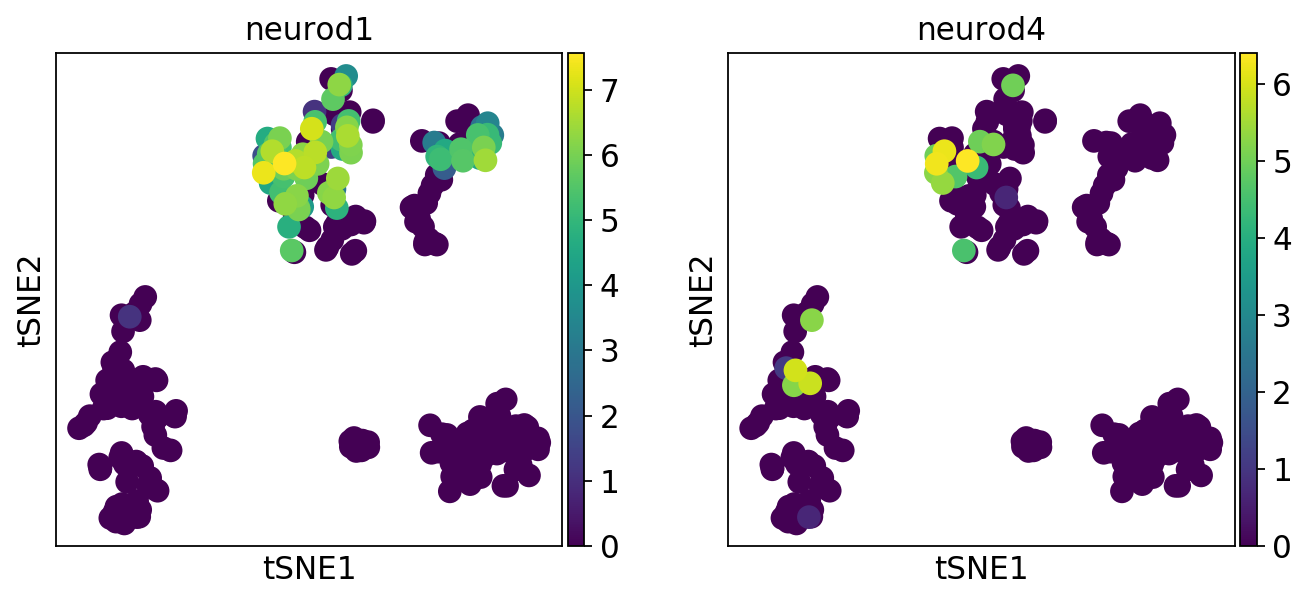

In [63]:
sc.pl.tsne(adata, color=['neurod1', 'neurod4'])

In [64]:
adata.rename_categories('louvain', ['NBN.1', 'RG',  'NBN.2', 'MN', 'OPC'])
adata.obs['louvain'].cat.reorder_categories(['RG', 'NBN.1', 'NBN.2', 'MN', 'OPC'], 
                                            inplace = True)

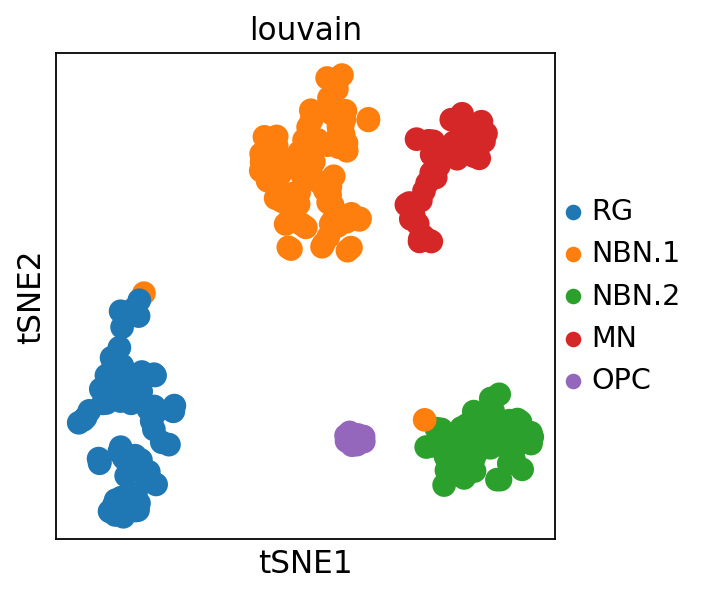

In [65]:
sc.pl.tsne(adata, color='louvain')

## Response to Reviewer 2

In [66]:
sc.settings.verbosity = 3

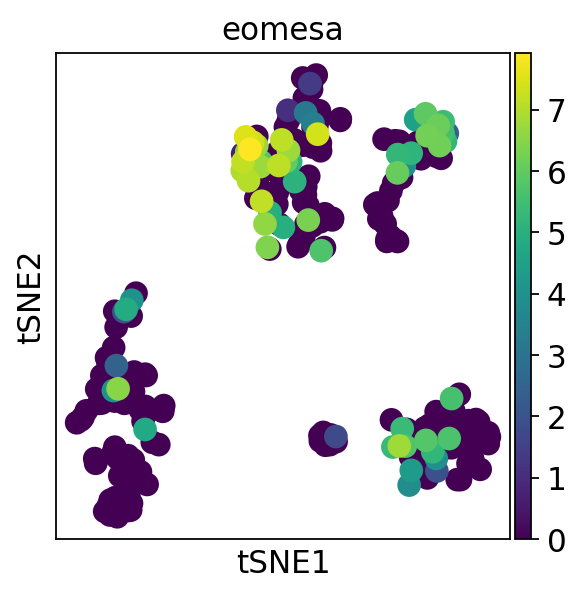

In [67]:
sc.pl.tsne(adata, color='eomesa')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain_fine', the cluster labels (adata.obs, categorical)


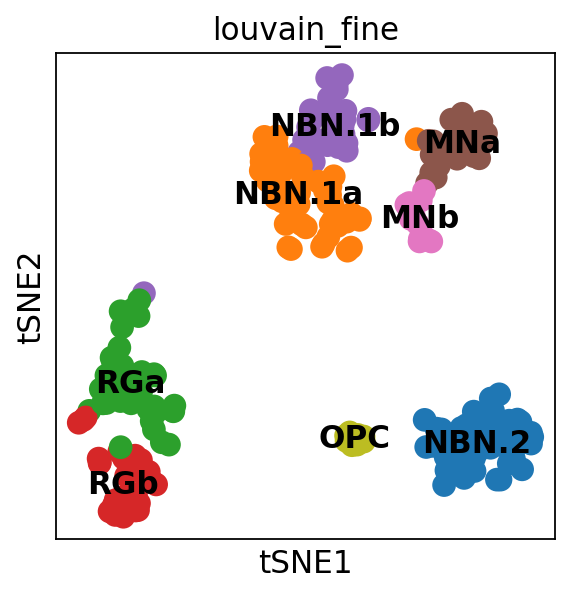

In [68]:
sc.tl.louvain(adata, resolution=0.83, key_added='louvain_fine')
adata.rename_categories('louvain_fine', ['NBN.2', 'NBN.1a', 'RGa', 'RGb', 'NBN.1b', 'MNa', 'MNb', 'OPC'])
sc.pl.tsne(adata, color=['louvain_fine'], legend_loc='on data')

In [69]:
adata.obs['louvain_fine'].value_counts()

NBN.2     56
NBN.1a    51
RGa       43
NBN.1b    31
RGb       31
MNa       29
MNb       13
OPC       10
Name: louvain_fine, dtype: int64

ranking genes
    finished (0:00:00.66) --> added to `.uns['rank_genes_louvain_fine']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


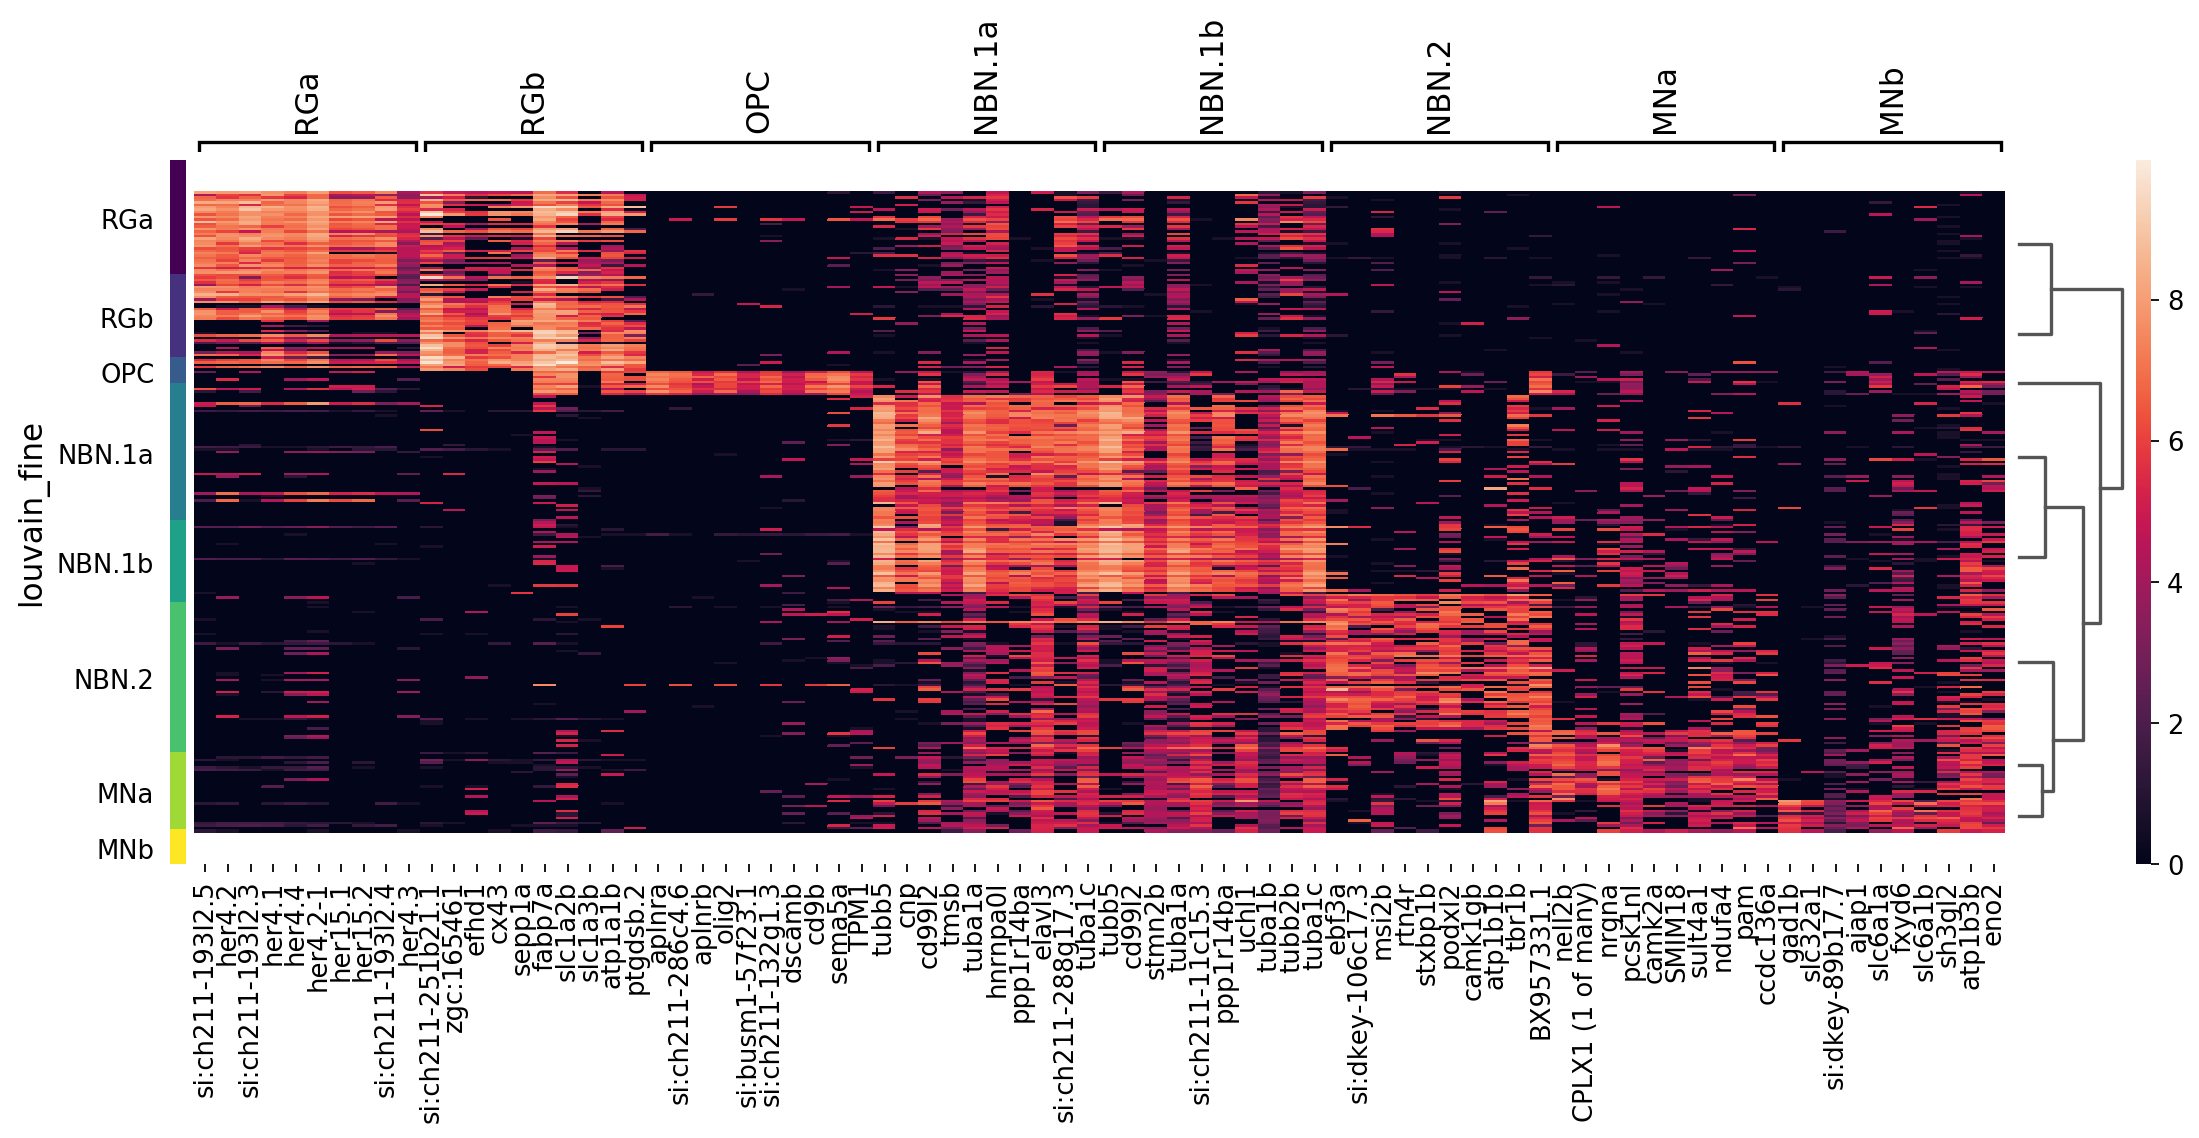

In [70]:
sc.tl.rank_genes_groups(adata, 'louvain_fine', key_added='rank_genes_louvain_fine')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_louvain_fine', dendrogram=True)

In [71]:
adata.obs['louvain_fine'].value_counts()

NBN.2     56
NBN.1a    51
RGa       43
NBN.1b    31
RGb       31
MNa       29
MNb       13
OPC       10
Name: louvain_fine, dtype: int64

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


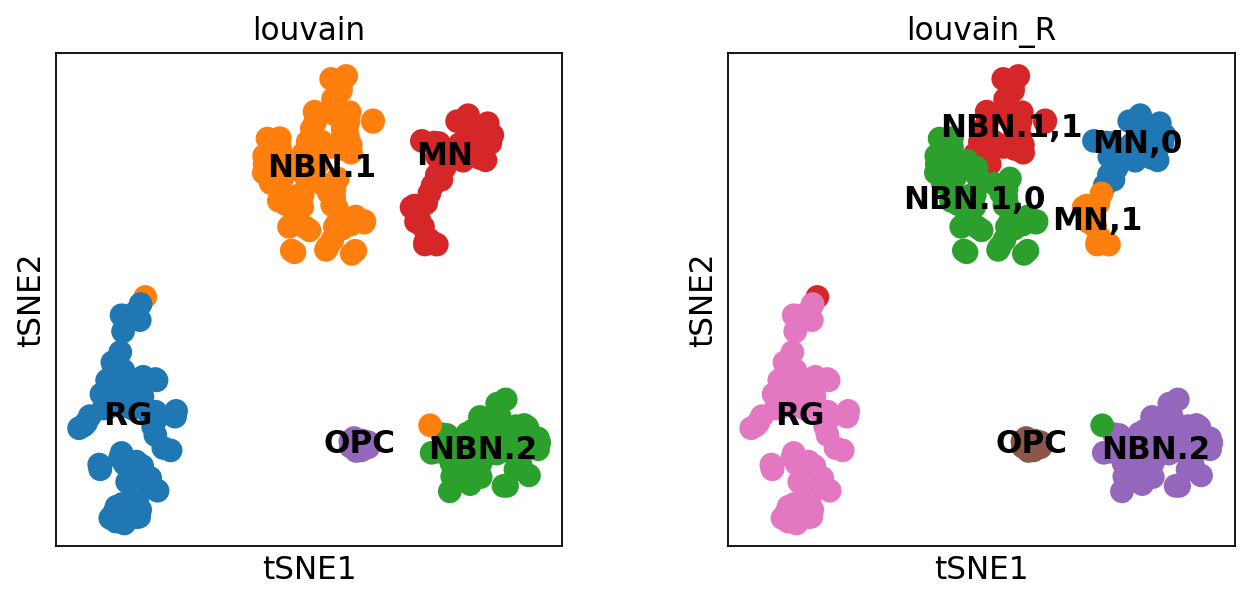

In [72]:
sc.tl.louvain(adata, resolution=0.3, restrict_to=('louvain', ['NBN.1']))
sc.tl.louvain(adata, resolution=0.3, restrict_to=('louvain_R', ['MN']), key_added='louvain_R')
sc.pl.tsne(adata, color=['louvain', 'louvain_R'], legend_loc='on data')

ranking genes
    finished (0:00:00.41) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


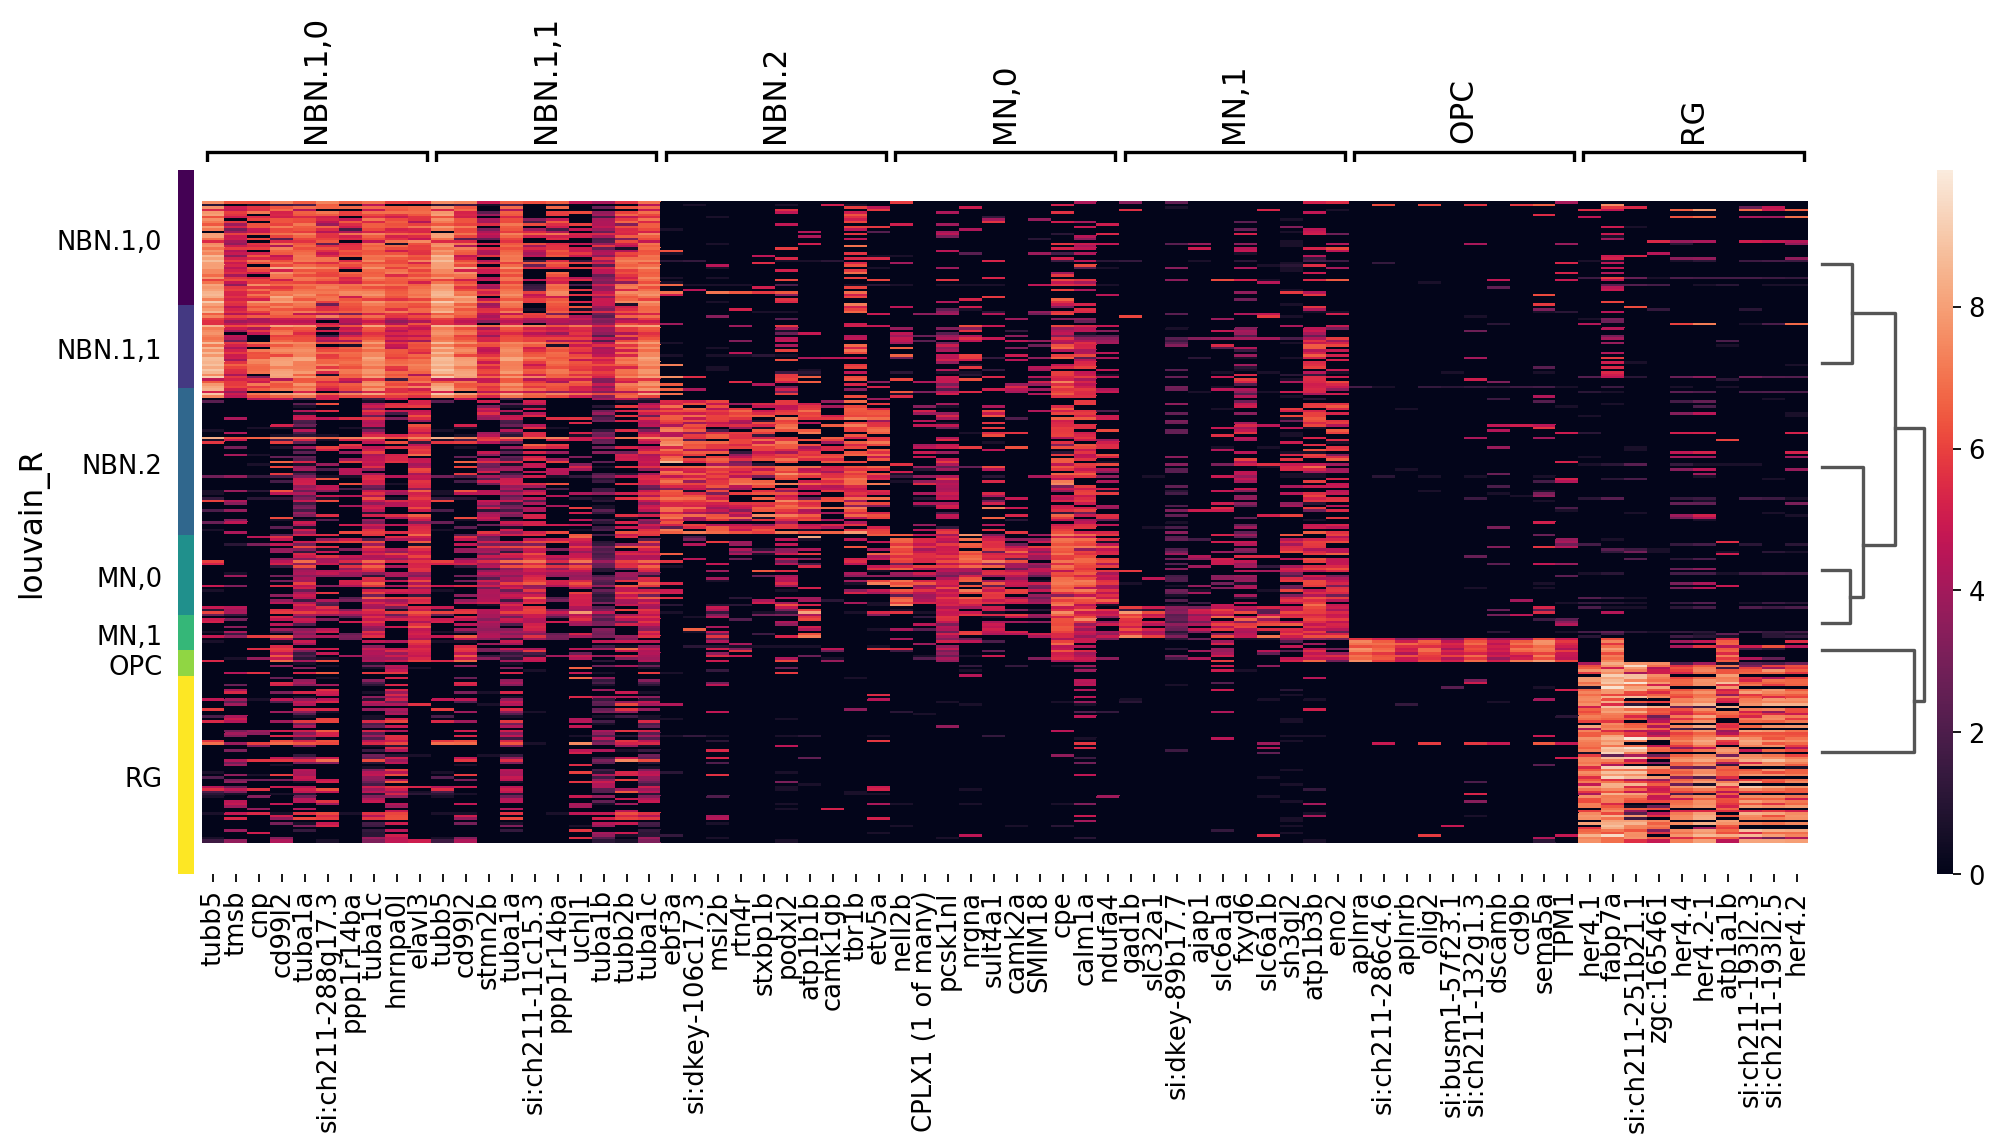

In [73]:
sc.tl.rank_genes_groups(adata, 'louvain_R')
sc.pl.rank_genes_groups_heatmap(adata)

ranking genes
    finished (0:00:00.14) --> added to `.uns['rank_genes_MN,1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.15) --> added to `.uns['rank_genes_MN,0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


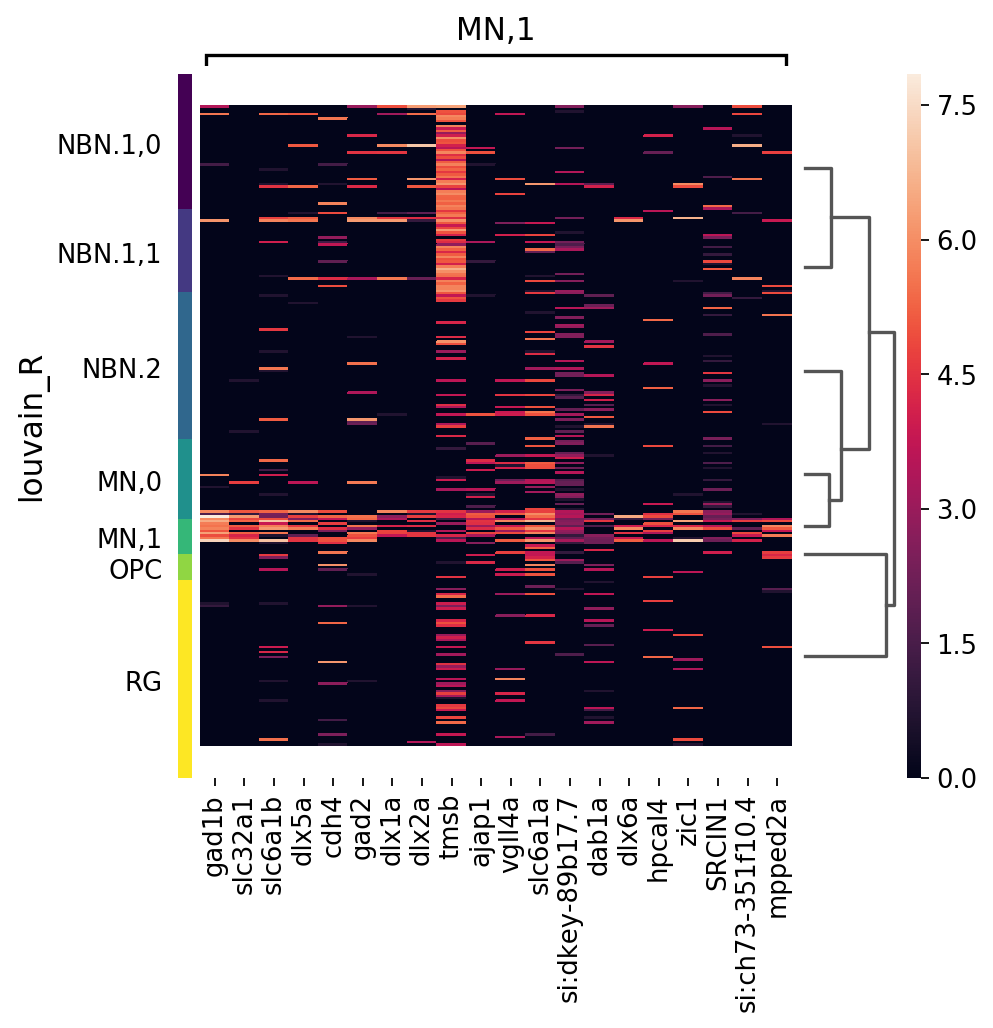

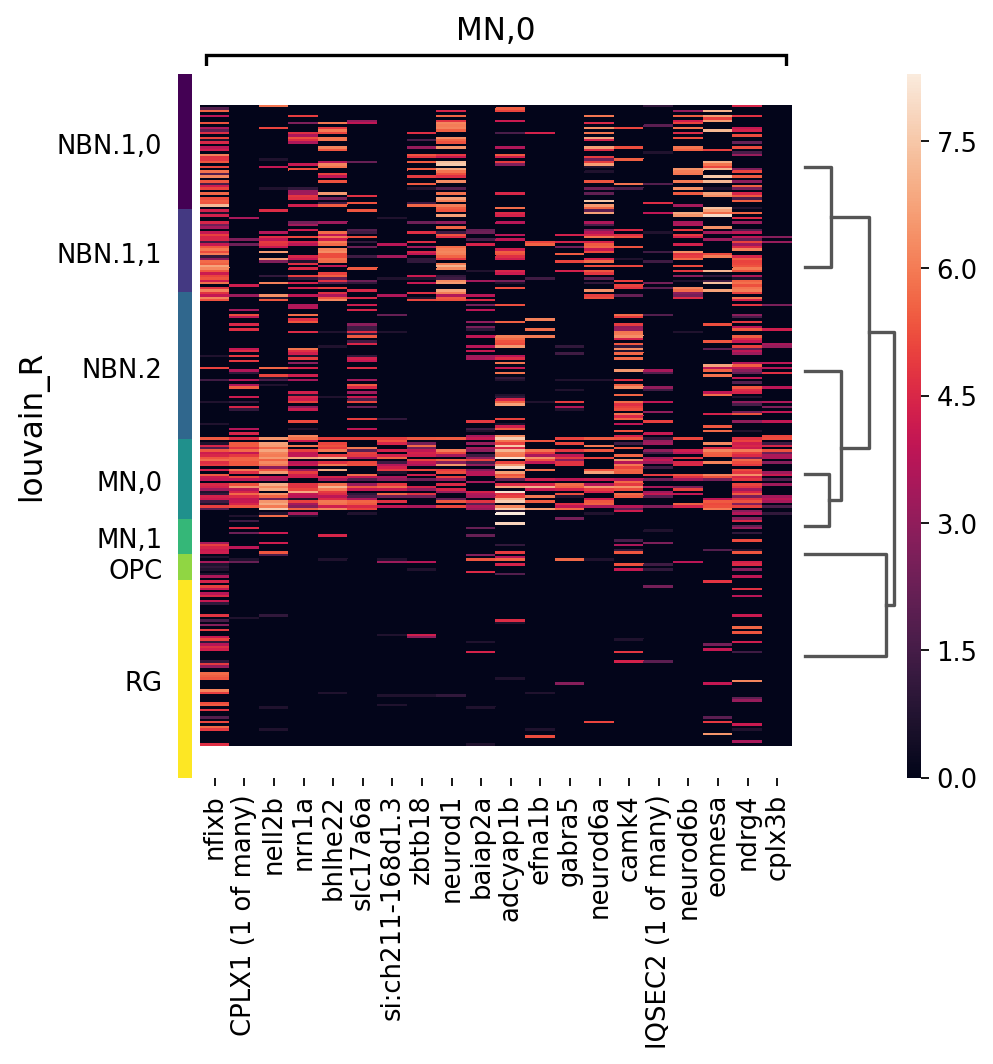

In [74]:
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['MN,0'], key_added='rank_genes_MN,1', reference='MN,1')
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['MN,1'], key_added='rank_genes_MN,0', reference='MN,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_MN,0', n_genes=20)
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_MN,1', n_genes=20)

ranking genes
    finished (0:00:00.31) --> added to `.uns['rank_genes_NBN.1,1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.13) --> added to `.uns['rank_genes_NBN.1,0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


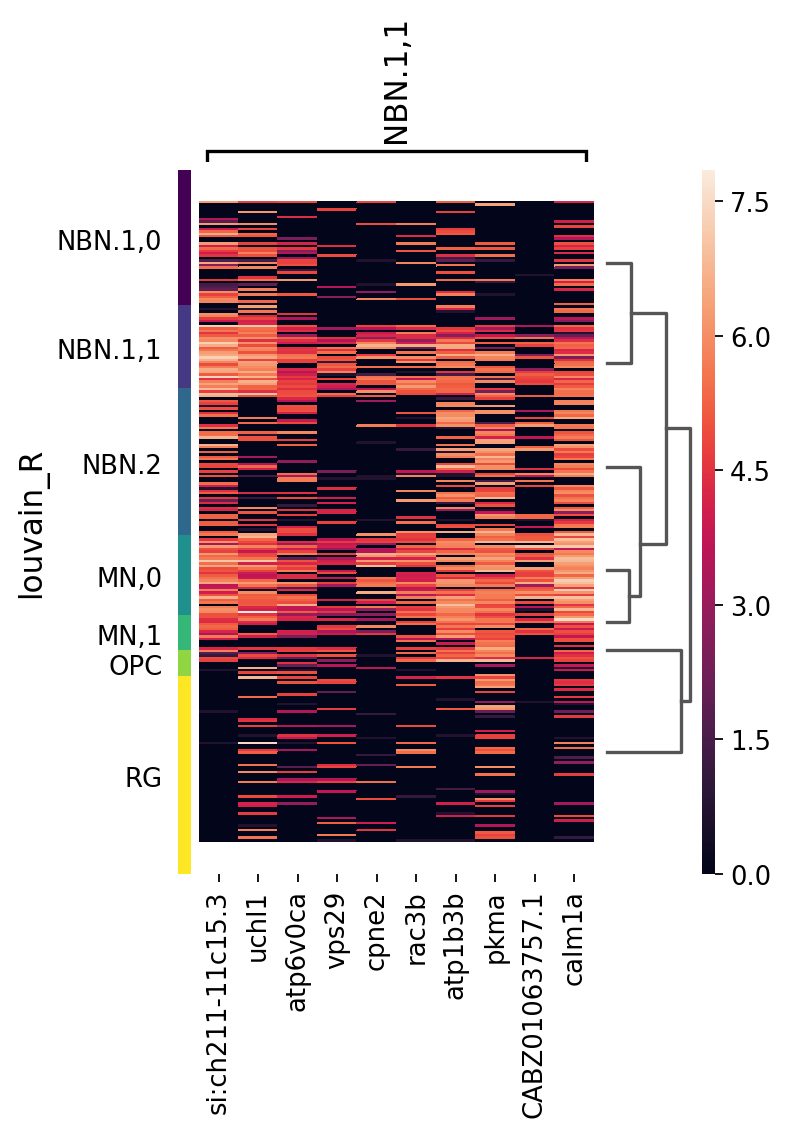

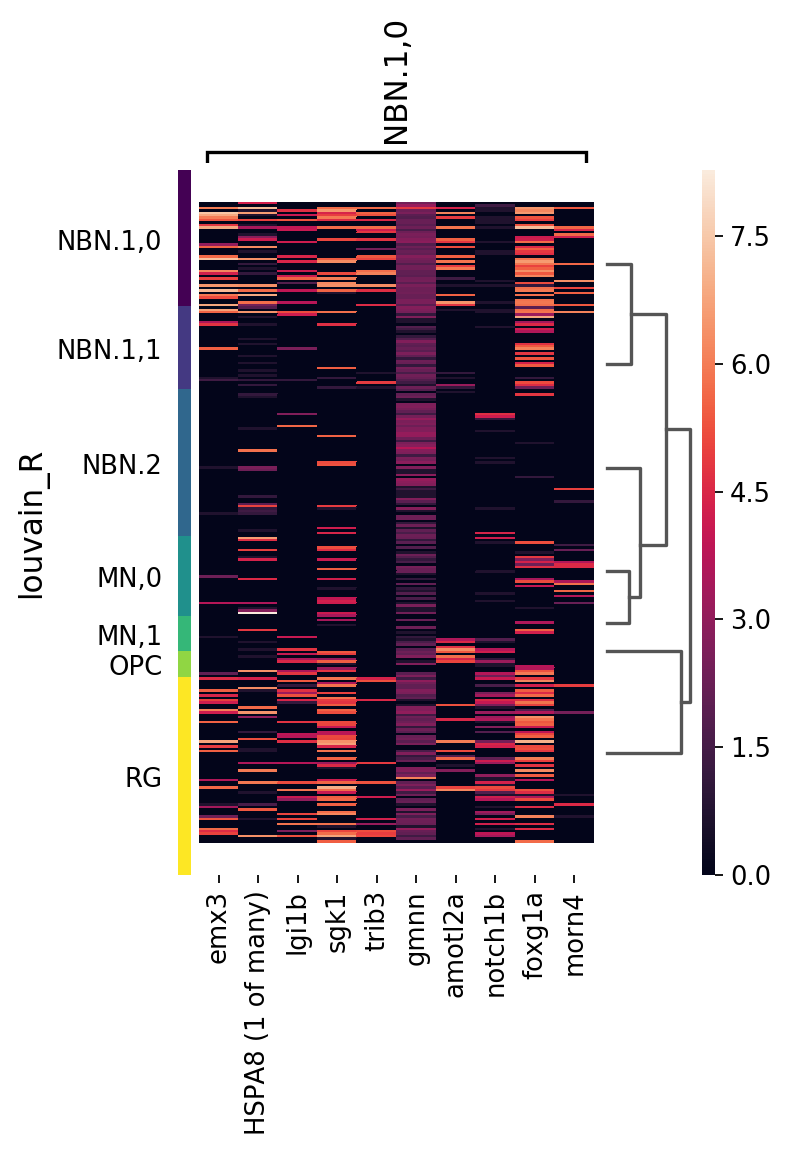

In [75]:
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['NBN.1,0'], key_added='rank_genes_NBN.1,1', reference='NBN.1,1')
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['NBN.1,1'], key_added='rank_genes_NBN.1,0', reference='NBN.1,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_NBN.1,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_NBN.1,1')

## Cell numbers

In [76]:
adata.obs.groupby('louvain').size()

louvain
RG       74
NBN.1    82
NBN.2    55
MN       43
OPC      10
dtype: int64

In [77]:
table = adata.obs.groupby(['sort_gate', 'louvain']).size().reset_index().pivot(
    index='sort_gate', columns='louvain', values=0).fillna(0).astype(int)
table

louvain    RG  NBN.1  NBN.2  MN  OPC
sort_gate                           
RG         74      2      0   0    0
NBN         0     78     54  20   10
MN          0      2      1  23    0

In [78]:
robjects.globalenv['tab'] = table.values
print(robjects.r("fisher.test(tab, simulate.p.value=TRUE, B=2000)"))


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  tab
p-value = 0.0004998
alternative hypothesis: two.sided




# Fig. 2B

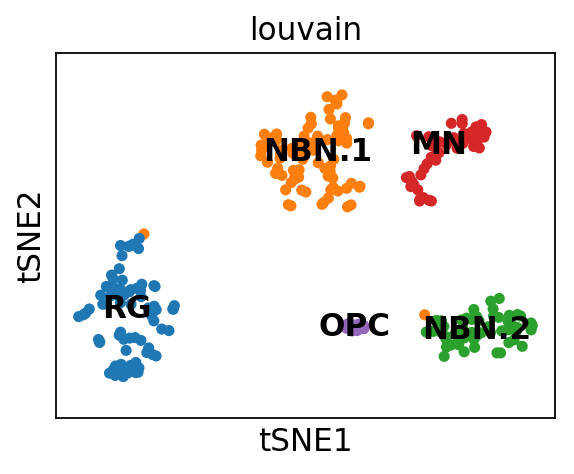

In [79]:
ax = sc.pl.tsne(adata, color=['louvain'],
          legend_loc='on data', size=100, show=False)
fig = plt.gcf()
fig.set_size_inches(4, 3)
ax.set_aspect('equal', adjustable='datalim')
plt.savefig('../../results/figures/tsne_2Ba.pdf', dpi=300, bbox_inches='tight')
plt.show()

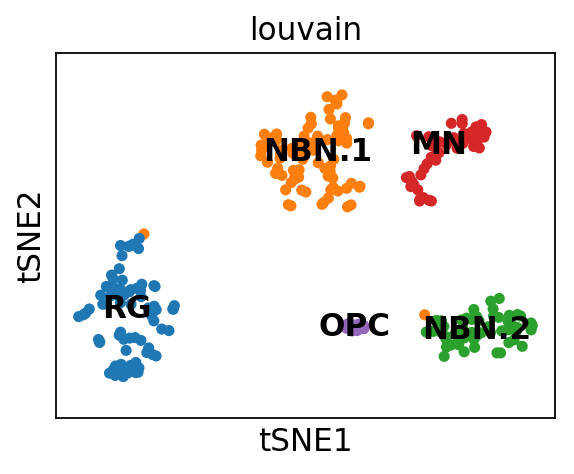

In [80]:
ax = sc.pl.tsne(adata, color=['louvain'],
          legend_loc='on data', size=100, show=False)
fig = plt.gcf()
fig.set_size_inches(4, 3)
ax.set_aspect('equal', adjustable='datalim')
plt.savefig('../../results/figures/tsne_2Ba.pdf', dpi=300, bbox_inches='tight')
plt.show()

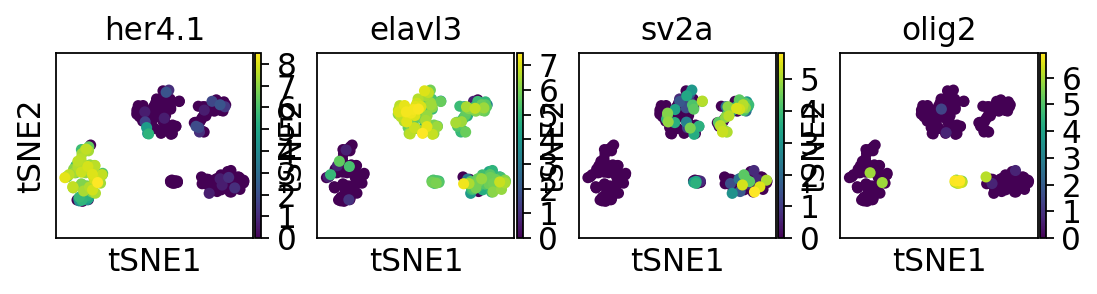

In [81]:
axs = sc.pl.tsne(adata, color=['her4.1', 'elavl3', 'sv2a', 'olig2'],
          legend_loc='on data', size=100, show=False)
for ax in axs:
    ax.set_aspect('equal', adjustable='datalim')
fig = plt.gcf()
fig.set_size_inches(0.5*19.32 * 7.4/8.2 * 0.9, 2*3/4)
plt.savefig('../../results/figures/tsne_2Bb.pdf', dpi=300, bbox_inches='tight')

# Fig. Supplement tSNE

si:ch211-2111b21.1 (encoding fgfbp3)

In [82]:
markers['RGb'] = ['fabp7a', 'her4.1', 'glula', 'si:ch211-251b21.1', 'zgc:165461', 'atp1a1b',
                  'sepp1a', 'mdka']
markers['NBN.1b'] = ['tubb5', 'cd99l2', 'ppp1r14ba', 'cnp', 'tubb2b']
markers['NBN.2b'] = ['ebf3a', 'si:dkey-106c17.3', 'tbr1b', 'msi2b', 'podxl2']
markers['MNb'] = ['si:ch211-276i12.12', 'pam', 'gad1b', 'sybu', 'ngb']
markers['OPCb'] = ['aplnra', 'sema5a', 'si:ch211-286c4.6', 'traf4a', 'cd82a']

In [83]:
colors = ['sort_gate'] +  markers['RGb'] + markers['NBN.1b'] + markers['NBN.2b'] +\
          markers['MNb'] + markers['OPCb'] 
print(colors)

['sort_gate', 'fabp7a', 'her4.1', 'glula', 'si:ch211-251b21.1', 'zgc:165461', 'atp1a1b', 'sepp1a', 'mdka', 'tubb5', 'cd99l2', 'ppp1r14ba', 'cnp', 'tubb2b', 'ebf3a', 'si:dkey-106c17.3', 'tbr1b', 'msi2b', 'podxl2', 'si:ch211-276i12.12', 'pam', 'gad1b', 'sybu', 'ngb', 'aplnra', 'sema5a', 'si:ch211-286c4.6', 'traf4a', 'cd82a']


In [84]:
# axs = sc.pl.tsne(adata, color=colors, size=100, show=False)

# for ax in axs:
#     ax.set_aspect('equal', adjustable='datalim')
    
# plt.savefig('../../results/figures/tsne_supplement.pdf', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# Fig. Supplement PCA

saving figure to file ../../results/figures/pca_supplement.pdf


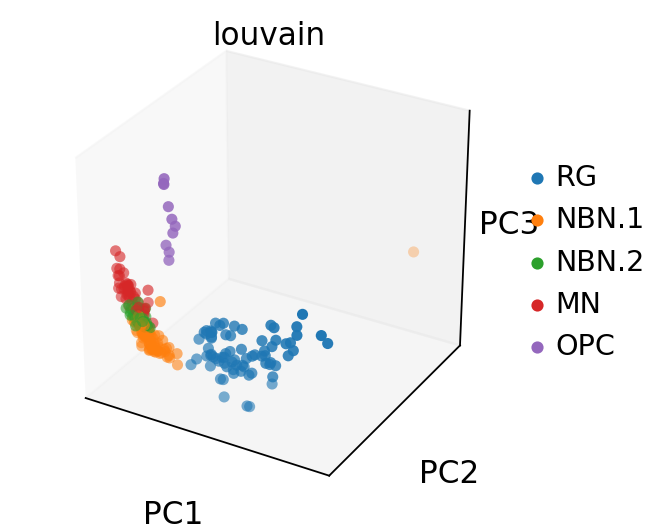

In [85]:
sc.pl.pca(adata, color='louvain', projection='3d', size=100, save='_supplement')

# Fig. Supplement Diffusion Map

saving figure to file ../../results/figures/diffmap_supplement.pdf


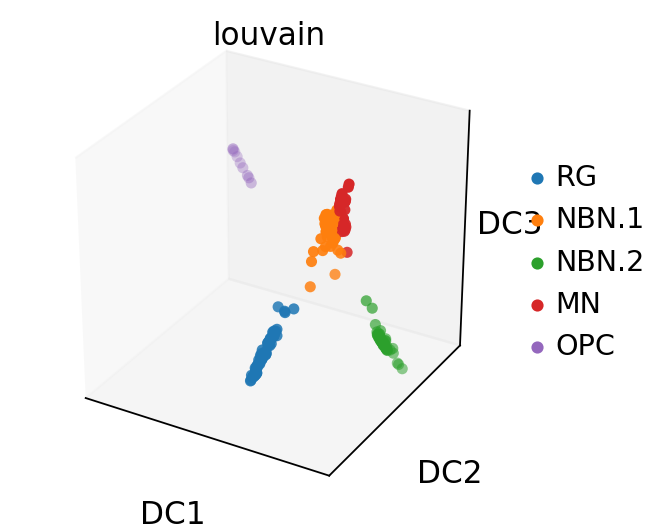

In [86]:
sc.pl.diffmap(adata, color='louvain', projection='3d', save='_supplement', size=100)

# Marker Genes

## Find marker genes

In [87]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg', multi_class='multinomial', solver='lbfgs')

ranking genes
    finished (0:00:03.70) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



# Fig 2.C

saving figure to file ../../results/figures/heatmap_2C.pdf


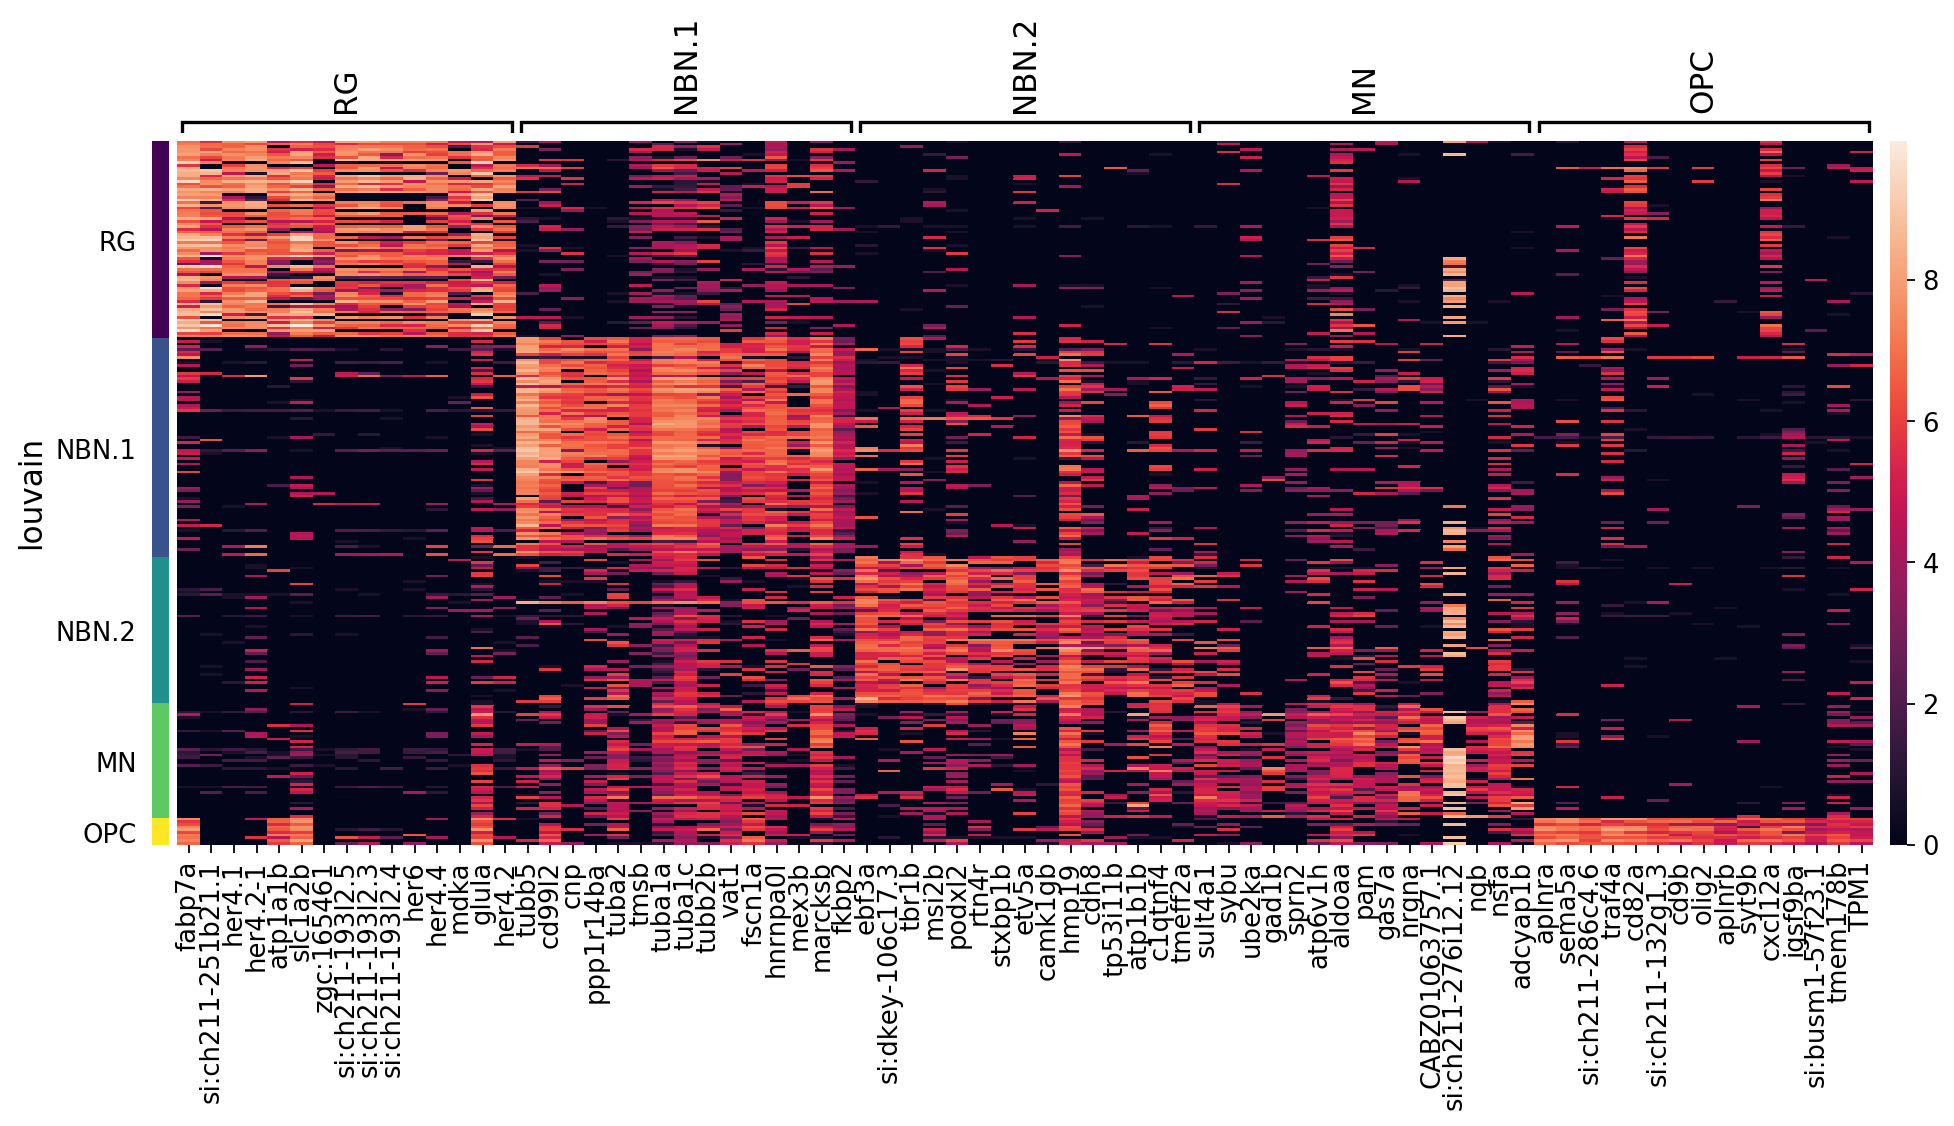

In [88]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=15, dendrogram=False,
                               save='_2C')

In [89]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
adata.uns['DE'] = pd.DataFrame({group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores']})

max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
display(adata.uns['DE'])
pd.set_option('display.max_rows', max_rows)
adata.uns['DE'].to_excel('../../results/marker_genes.xlsx')

RG_names  RG_scores        NBN.1_names  NBN.1_scores  \
0               fabp7a   0.025689              tubb5      0.031930   
1    si:ch211-251b21.1   0.024565             cd99l2      0.023146   
2               her4.1   0.023604                cnp      0.020517   
3             her4.2-1   0.019603          ppp1r14ba      0.019347   
4              atp1a1b   0.019523              tuba2      0.017808   
5              slc1a2b   0.019303               tmsb      0.015243   
6           zgc:165461   0.019195             tuba1a      0.014911   
7     si:ch211-193l2.5   0.019059             tuba1c      0.014677   
8     si:ch211-193l2.3   0.018975             tubb2b      0.014478   
9     si:ch211-193l2.4   0.018882               vat1      0.014475   
10                her6   0.018570             fscn1a      0.013940   
11              her4.4   0.017758           hnrnpa0l      0.013919   
12                mdka   0.017059              mex3b      0.013658   
13               glula   0.016820            marcksb      0.013634   
14              her4.2   0.016791              fkbp2      0.013613   
15             slc1a3b   0.016461               hn1b      0.013577   
16               s100b   0.016110             kdm6bb      0.013303   
17                cx43   0.015905             mllt11      0.013230   
18             her15.2   0.015838             gpm6ab      0.012878   
19             her15.1   0.015527             rcan1a      0.012866   
20                her9   0.015402             zfpm2a      0.012797   
21              sepp1a   0.014654            dpysl5a      0.012795   
22                 dla   0.013682             tubb4b      0.012740   
23              atp1b4   0.013590  si:ch211-288g17.3      0.012709   
24               fads2   0.013519   si:ch73-281n10.2      0.011969   
25               efhd1   0.013133             elavl3      0.011692   
26              cox4i2   0.012378               rps6      0.011637   
27                lix1   0.012286            nme2b.1      0.011622   
28                 ptn   0.012186                jun      0.011526   
29               s1pr1   0.011639               cct4      0.011520   
30    si:ch211-193l2.6   0.011555                vim      0.011415   
31             zfp36l2   0.011520               syt4      0.011332   
32               cd82a   0.011422              actb1      0.011156   
33               grm2b   0.011327              rtn1b      0.011095   
34                mdkb   0.011212             stmn2a      0.011052   
35               ccnd1   0.010912              RPS17      0.010998   
36              ppap2d   0.010766         zgc:153426      0.010972   
37              her4.3   0.010696           hist2h2l      0.010808   
38                 boc   0.010284             fmnl2b      0.010777   
39            cyp19a1b   0.009975               cct5      0.010711   
40               gstp1   0.009938             stmn1b      0.010644   
41               dap1b   0.009929            neurod1      0.010633   
42             cxcl12a   0.009908              CRIP2      0.010615   
43              nell2a   0.009838                erh      0.010601   
44               luzp2   0.009690  si:ch211-195b15.8      0.010464   
45                her2   0.009640         zgc:162707      0.010395   
46              sox19a   0.009338              rps3a      0.010390   
47             dap1b-1   0.009328             ahsa1b      0.010382   
48                 id1   0.009323             hspa4a      0.010343   
49                lfng   0.009311              zc4h2      0.010340   
50          zgc:153704   0.009285              kdm1a      0.010127   
51               glulb   0.009172               ybx1      0.010064   
52              sdcbp2   0.009068             sumo2b      0.009858   
53    si:ch211-286b5.5   0.009062            slc38a2      0.009831   
54              mfge8a   0.008993  si:ch211-194k22.8      0.009824   
55  si:ch1073-303k11.2   0.008954             tuba1b      0.009783   
56                sox3  

# FACS vs RNA

In [90]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain'] == 'RG')[-1]
print(f"root cell: {adata.obs.iloc[np.flatnonzero(adata.obs['louvain'] == 'RG')[-1]]['sample_id']}")
# adata2.uns['iroot'] = adata2.obsm['X_diffmap'][:,1].argmin()
sc.tl.dpt(adata, n_branchings=1)

root cell: RG-5_03_D09
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.12) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


In [91]:
for name in ['EGFP', 'mCherry']:
    adata.obs[f'log_{name}'] /= adata.obs[f'log_{name}'].max()
    adata.obs[f'log_{name}_FACS'] /= adata.obs[f'log_{name}_FACS'].max()

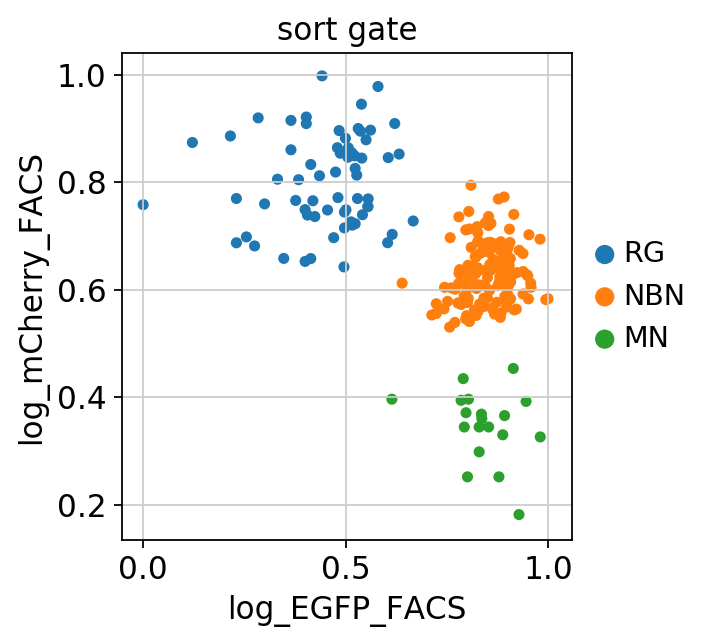

In [92]:
sc.pl.scatter(adata, x=f'log_EGFP_FACS', y=f'log_mCherry_FACS', size=100, color='sort_gate')

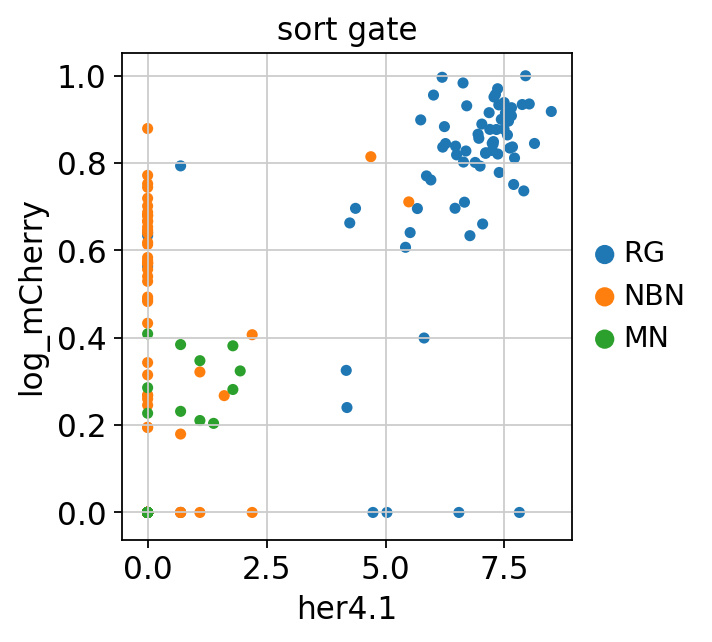

In [93]:
sc.pl.scatter(adata, x='her4.1', y='log_mCherry', size=100, color='sort_gate')

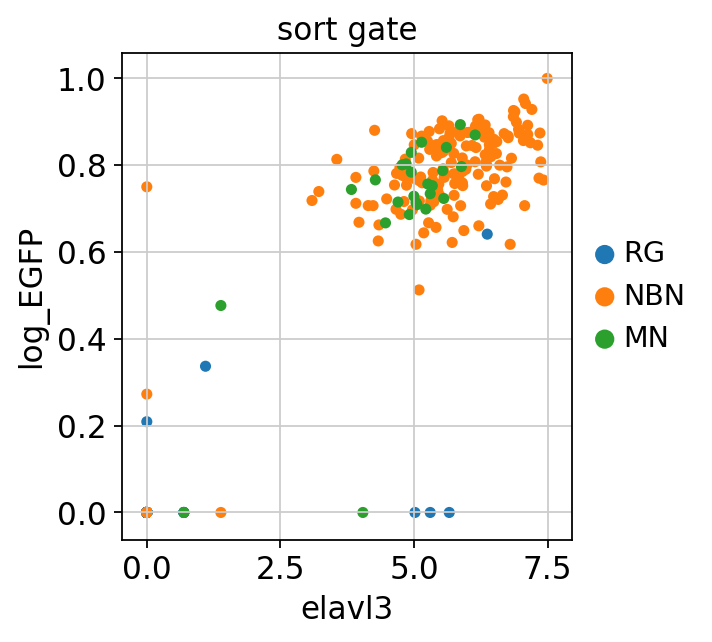

In [112]:
sc.pl.scatter(adata, x='elavl3', y='log_EGFP', size=100, color='sort_gate')

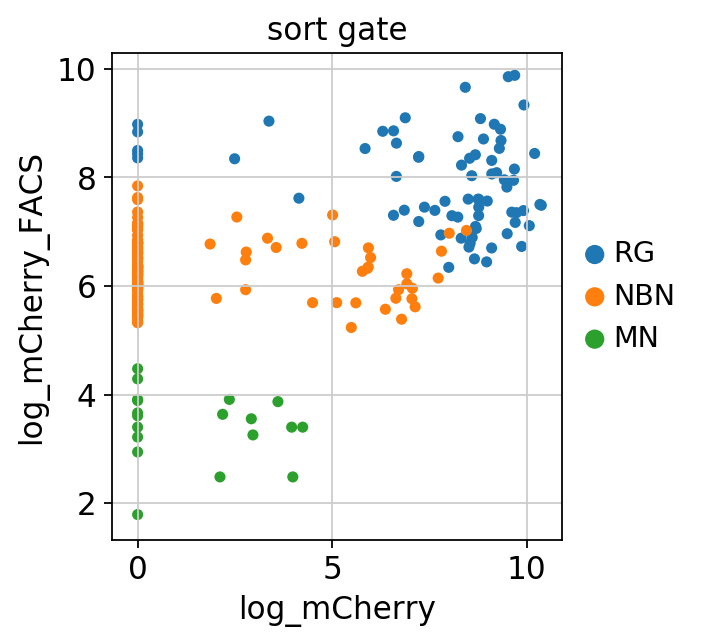

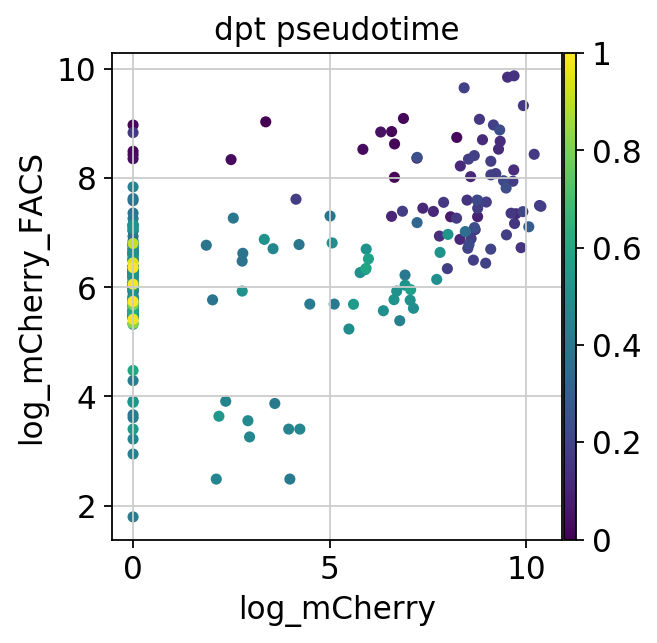

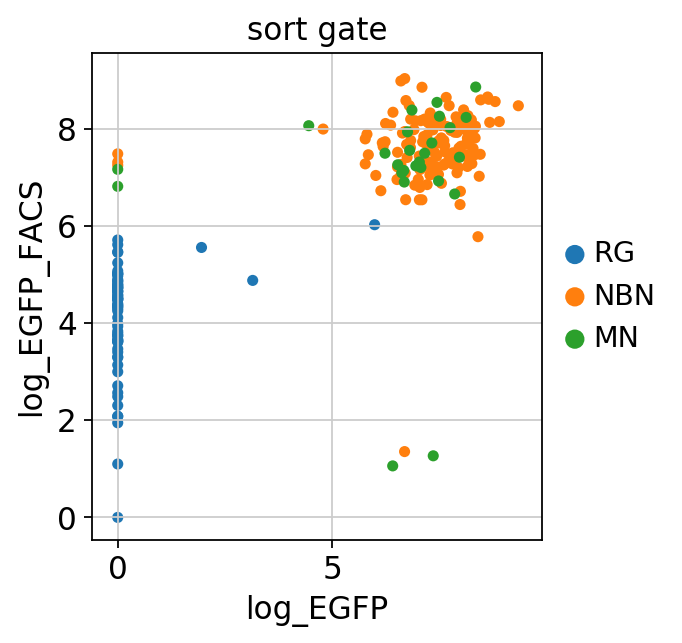

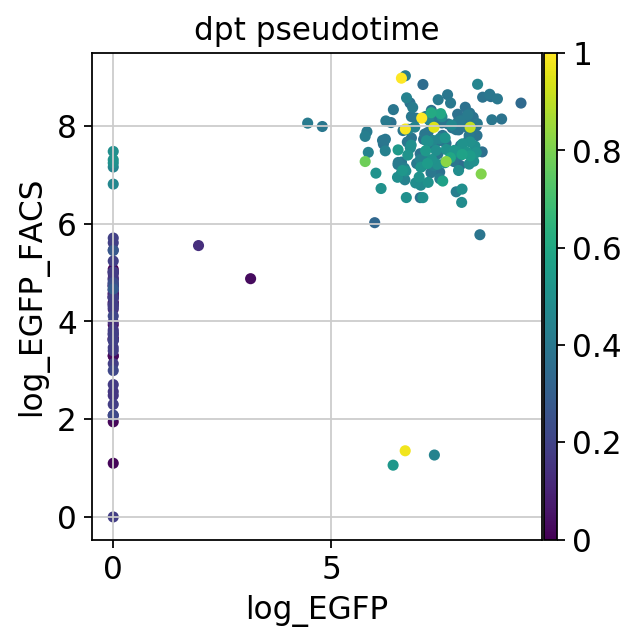

In [94]:
for name in ['mCherry', 'EGFP']:
#     sc.pl.scatter(adata, x=name, y=f'{name}_FACS', size=100, color='sort_gate')
    sc.pl.scatter(adata, x=f'log_{name}', y=f'log_{name}_FACS', size=100, color='sort_gate')
    sc.pl.scatter(adata, x=f'log_{name}', y=f'log_{name}_FACS', size=100, color='dpt_pseudotime')

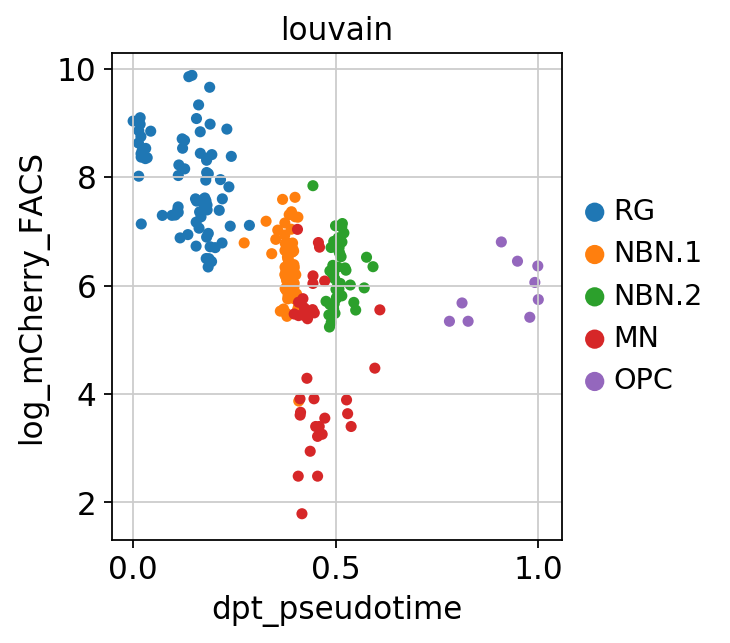

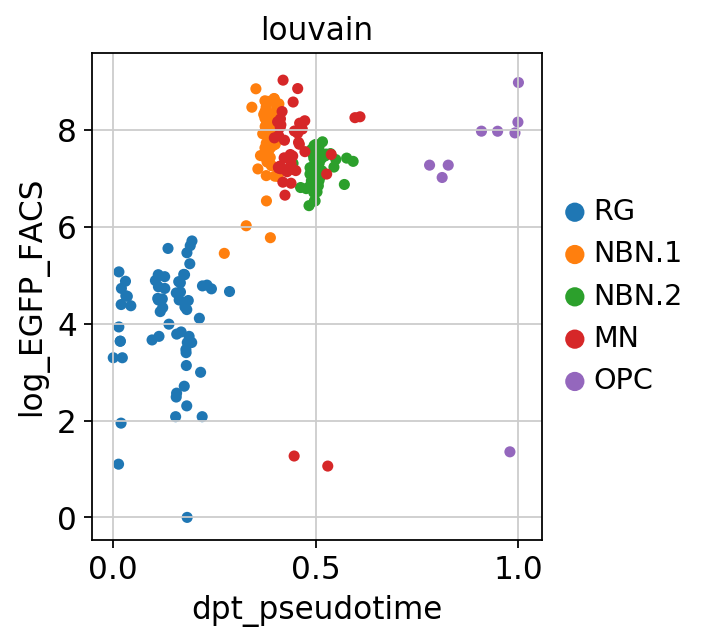

In [95]:
for name in ['mCherry', 'EGFP']:
#     sc.pl.scatter(adata, x=name, y=f'{name}_FACS', size=100, color='sort_gate')
    sc.pl.scatter(adata, x=f'dpt_pseudotime', y=f'log_{name}_FACS', size=100, color='louvain')

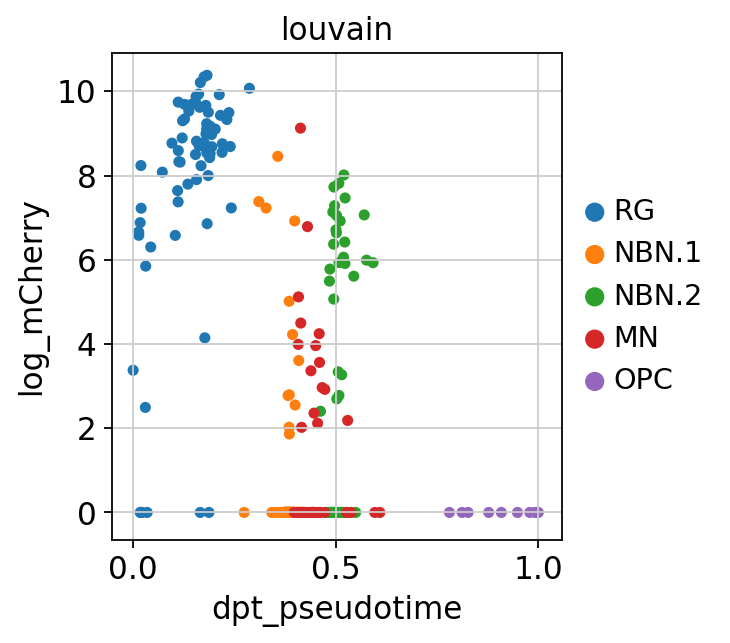

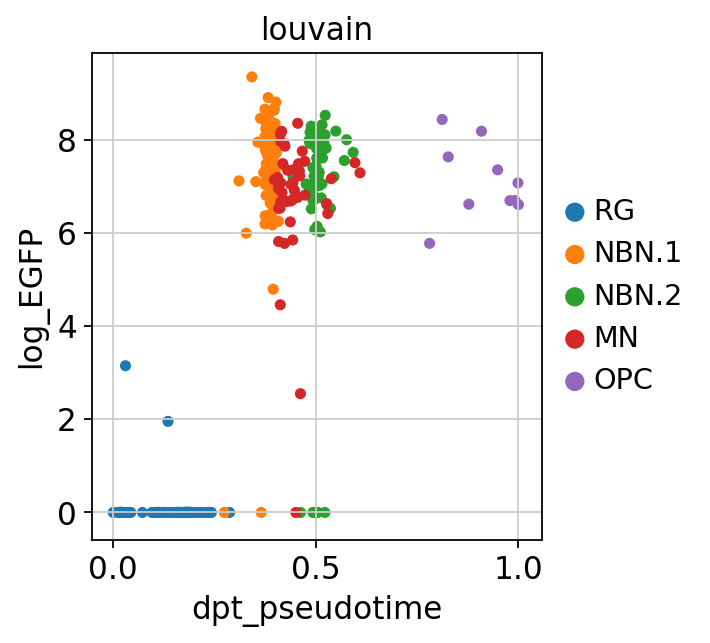

In [96]:
for name in ['mCherry', 'EGFP']:
#     sc.pl.scatter(adata, x=name, y=f'{name}_FACS', size=100, color='sort_gate')
    sc.pl.scatter(adata, x=f'dpt_pseudotime', y=f'log_{name}', size=100, color='louvain')

In [103]:
for name in ['mCherry', 'EGFP']:
    adata.obs[f'diff_{name}'] = adata.obs[f'log_{name}_FACS'] - adata.obs[f'log_{name}']

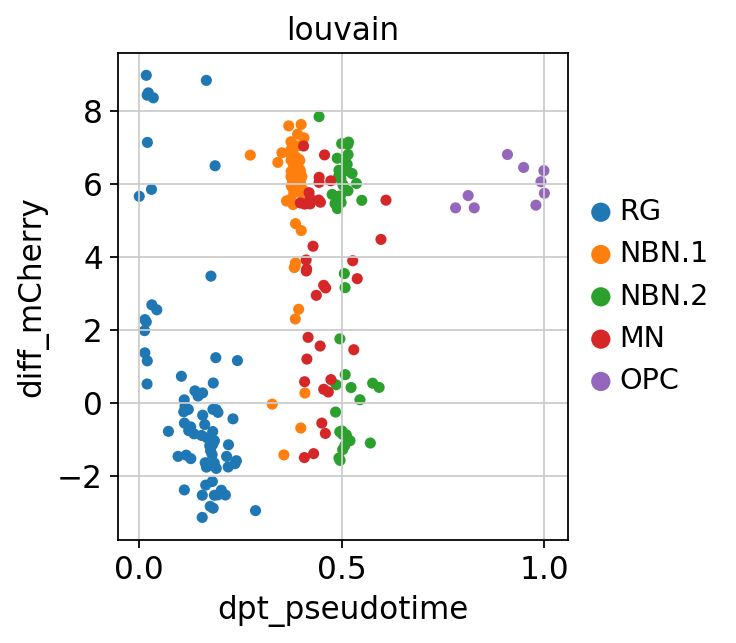

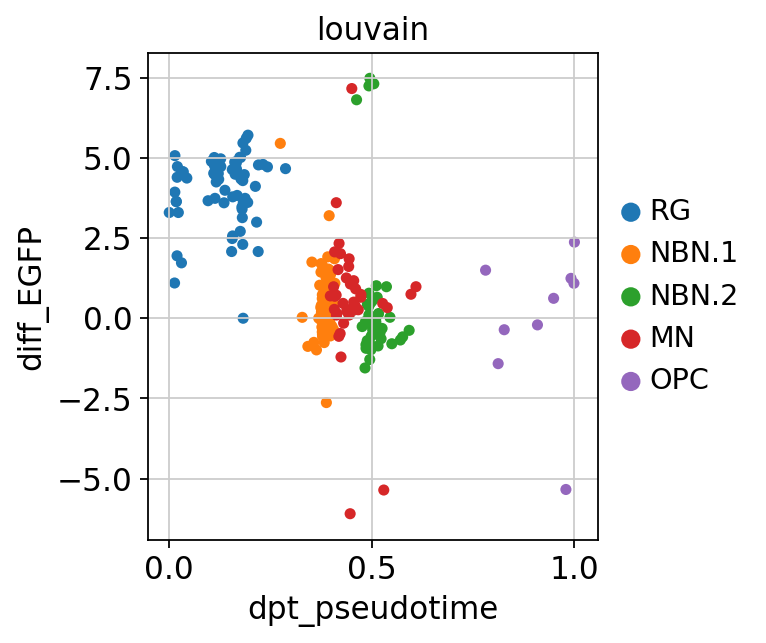

In [104]:
for name in ['mCherry', 'EGFP']:    
    sc.pl.scatter(adata, x=f'dpt_pseudotime', y=f'diff_{name}', size=100, color='louvain')

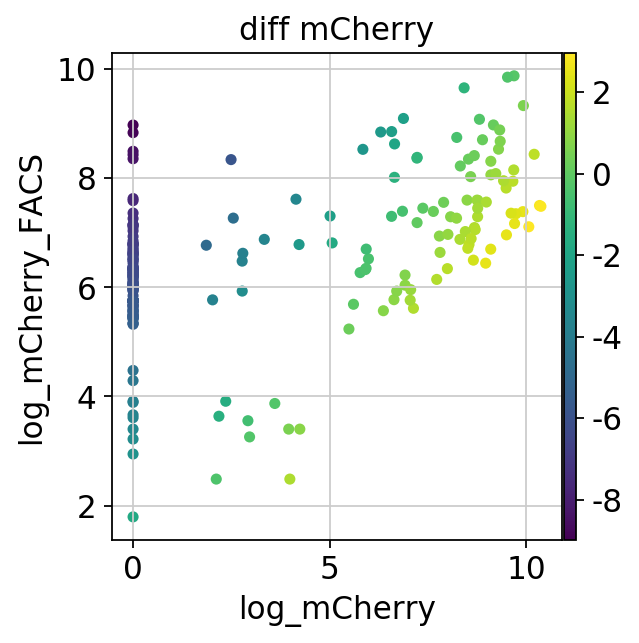

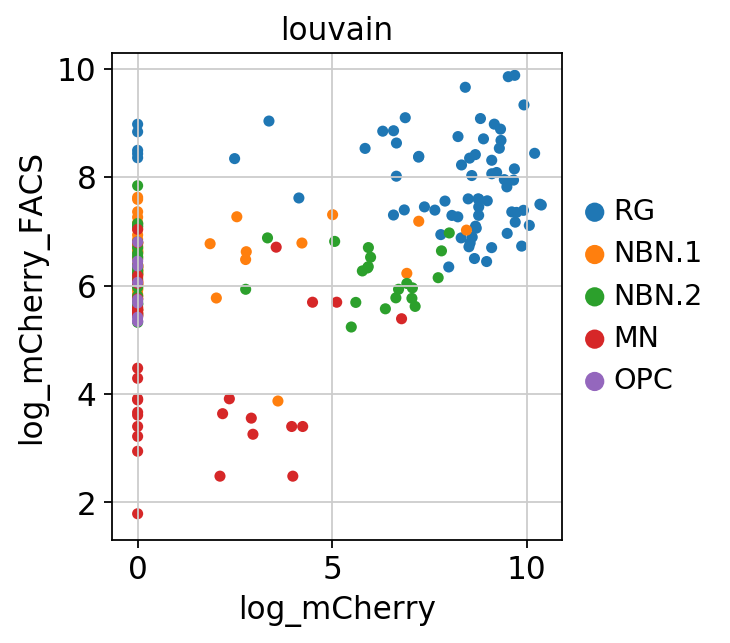

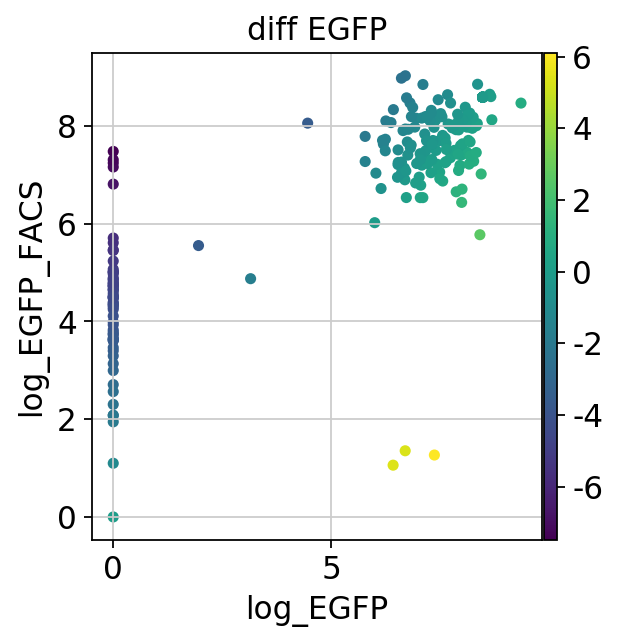

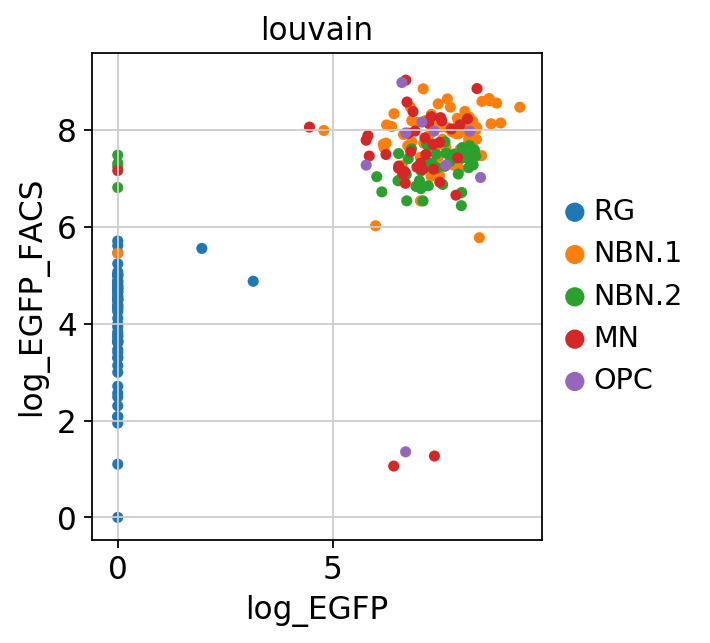

In [101]:
for name in ['mCherry', 'EGFP']:
#     sc.pl.scatter(adata, x=name, y=f'{name}_FACS', size=100, color='sort_gate')
    sc.pl.scatter(adata, x=f'log_{name}', y=f'log_{name}_FACS', size=100, color=f'diff_{name}')
    sc.pl.scatter(adata, x=f'log_{name}', y=f'log_{name}_FACS', size=100, color=f'louvain')

# Export adata object

In [111]:
adata.layers['counts'] = adata_original[adata.obs_names][:,adata.var_names].X

In [112]:
adata.write('../../results/zebrabrain.h5ad')

# Drop OPCs

In [ ]:
adata2 = adata[adata.obs['louvain'] != 'OPC'].copy()

In [ ]:
adata2.uns['louvain_colors'] = [tuple(color) for color in adata2.uns['louvain_colors']]

## PCA

In [ ]:
sc.tl.pca(adata2, svd_solver='arpack')
sc.pl.pca(adata2, color='louvain', projection='3d')

## tsne

In [ ]:
sc.tl.tsne(adata2, n_jobs=10, n_pcs=10, random_state=15, perplexity=40)
sc.tl.tsne(adata2, n_jobs=10, n_pcs=10, random_state=15, perplexity=40)
sc.pl.tsne(adata2, color='louvain', legend_loc='on data')

## UMAP

In [ ]:
sc.pp.neighbors(adata2, n_neighbors=15, n_pcs=10)
sc.tl.umap(adata2, random_state=42)
sc.pl.umap(adata2, color='louvain', legend_loc='on data', edges=True)

# DiffusionMap & DPT

In [ ]:
# sc.pp.neighbors(adata, n_neighbors=200, n_pcs=10)
sc.pp.neighbors(adata2, method='gauss', knn=False, n_neighbors=5, n_pcs=10, random_state=42)
sc.tl.diffmap(adata2, n_comps=10)
# adata2.uns['iroot'] = adata2.obsm['X_diffmap'][:,1].argmin()

In [ ]:
adata2.uns['iroot'] = np.flatnonzero(adata2.obs['louvain'] == 'RG')[-1]
print(f"root cell: {adata2.obs.iloc[np.flatnonzero(adata2.obs['louvain'] == 'RG')[-1]]['sample_id']}")
# adata2.uns['iroot'] = adata2.obsm['X_diffmap'][:,1].argmin()
sc.tl.dpt(adata2, n_branchings=1)

In [ ]:
mpl.rcParams['axes3d.grid'] = False
mpl.rcParams['axes3d.grid'] = False

In [ ]:
adata2.uns['iroot']

In [ ]:
r = np.zeros(254)
r[233] = 1

In [ ]:
adata2.obs['root'] = r

# Fig. 3A,B

In [ ]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime'] + markers['proliferation'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
plt.savefig('../../results/figures/diffmap_3AB.pdf', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(1.2*8, 1.2*2.4)
plt.savefig('../../results/figures/diffmap_3A.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime', 'sort_gate'],
                         projection='3d', show=False, frameon=True, size=50)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(2*1.2*8, 1.2*2.4)
# plt.savefig('../../results/figures/diffmap_3A.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
axs = sc.pl.diffmap(adata2, color=markers['proliferation'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(1.2*8, 1.2*2.4*2/3)
plt.savefig('../../results/figures/diffmap_3B.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
axs = sc.pl.diffmap(adata2, color=['sort_gate', 'log_EGFP', 'log_mCherry', 'log_EGFP_FACS'],
                         projection='3d', show=False, size=50)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
# fig = plt.gcf()
# fig.set_size_inches(1.2*8, 1.2*2.4*2/3)
# plt.savefig('../../results/figures/diffmap_3B.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Fig 3C

Needs to be rotated using Illustrator

In [ ]:
sc.pl.heatmap(adata2, var_names=['ccnd1', 'mki67', 'mcm5'], groupby='louvain', show=True, save='_3B')

# DEA proliferative RGS

## Based on ccnd1

In [ ]:
adata_RG = adata2[adata2.obs['louvain'] == 'RG']
del adata_RG.uns['iroot']

In [ ]:
adata_RG.obs['prol_ccnd1'] = pd.Series(
    adata_RG.raw[:, 'ccnd1'].X > 0
    ).astype('category').cat.rename_categories({False: 'ccnd1-', True: 'ccnd1+'}).values

In [ ]:
sc.tl.rank_genes_groups(adata_RG, 'prol_ccnd1', method='wilcoxon', key_added='rank_genes_ccnd1',
                       use_raw=True)

In [ ]:
ax = sc.pl.rank_genes_groups_heatmap(adata_RG, n_genes=25, key='rank_genes_ccnd1', 
                                dendrogram=False, save='_3C', use_raw=True, show=True)
fig=plt.gcf()
# fig.get_size_inches()
# fig.set_size_inches(1.2*3.4, 1.2*1.1)

In [ ]:
result = adata_RG.uns['rank_genes_ccnd1']
groups = result['names'].dtype.names
adata_RG.uns['DE'] = pd.DataFrame({group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores','pvals','pvals_adj', 'logfoldchanges']})

max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
display(adata_RG.uns['DE'])
pd.set_option('display.max_rows', max_rows)
adata_RG.uns['DE'].to_excel('../../results/marker_genes_proliferative_RG.xlsx')

### Overlap

Genes that are upregulated in ccnd1+ and are marker genes of NBN.1:

In [ ]:
overlap_genes = list(adata_RG.uns['DE']['ccnd1+_names'][
    adata_RG.uns['DE']['ccnd1+_names'].isin(pd.Series(adata.uns['rank_genes_groups']['names']['NBN.1']))
])

In [ ]:
s = ''
for gene in overlap_genes:
    s += gene
    s += ', '
print(s)

## Fig. Venn

In [ ]:
matplotlib_venn.venn2([set(adata_RG.uns['DE']['ccnd1+_names']), set(adata.uns['rank_genes_groups']['names']['NBN.1'])],
                     set_labels=['ccnd1+', 'NBN.1'],
                     set_colors=['#98df8a', (1.0, 0.4980392156862745, 0.054901960784313725)],
                     alpha=1)
plt.savefig('../../results/figures/venn_ccnd1pos_NBN1.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
matplotlib_venn.venn2([set(adata_RG.uns['DE']['ccnd1-_names']), set(adata.uns['rank_genes_groups']['names']['NBN.1'])],
                     set_labels=['ccnd1-', 'NBN.1'],
                     set_colors=[(0.1215686275, 0.4666666667, 0.7058823529), 
                                 (1.0, 0.4980392156862745, 0.054901960784313725)],
                     alpha=1)
plt.savefig('../../results/figures/venn_ccnd1neg_NBN1.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
matplotlib_venn.venn3([set(adata_RG.uns['DE']['ccnd1-_names']),
                       set(adata.uns['rank_genes_groups']['names']['NBN.1']),
                      set(adata_RG.uns['DE']['ccnd1+_names'])],
                     set_labels=['qRG', 'NBN.1', 'pRG'],
                     set_colors=['#98df8a',
                         (1.0, 0.4980392156862745, 0.054901960784313725),
                         1.2*np.array([0.1215686275, 0.4666666667, 0.7058823529]) 
                                 ],
                     alpha=1)
plt.savefig('../../results/figures/venn_pRG_NBN1_qRG.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Fig. 3D

In [ ]:
# neuro_genes = list(np.array(overlap_genes)[[1, 3, 4, 7, 10]])
neuro_genes = ['ascl1a', 'sox4a', 'tmsb', 'stmn1b']

In [ ]:
adata_RG.obs['n_neuro_genes'] = (adata_RG.raw[:, neuro_genes].X > 0).sum(axis=1)
# hist_prol = (adata_RG.raw[adata_RG.obs['prol_ccnd1'] == 'ccnd1+', :][:, neuro_genes].X > 0).sum(axis=1)

In [ ]:
plt.figure(figsize=(2,2))

sns.violinplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', cut=0, inner=None,
              palette='vlag')
sns.swarmplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', color="0.3")
sns.pointplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', linestyles='None', 
              color='1', markers='s')
plt.xlabel('')
plt.ylabel('# genes')
plt.savefig('../../results/figures/violin_3D.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
average = adata_RG.obs[['prol_ccnd1', 'n_neuro_genes']].groupby('prol_ccnd1').agg(['mean', 'median'])
average

### mannwhitneyu

In [ ]:
sp.stats.mannwhitneyu(adata_RG.obs.query('prol_ccnd1 == "ccnd1-"')['n_neuro_genes'].values,
                        adata_RG.obs.query('prol_ccnd1 == "ccnd1+"')['n_neuro_genes'].values,
                     alternative='less', use_continuity=False)

### Robustness against ccnd1+ threshold level

In [ ]:
sc.settings.verbosity = 0
for threshold in [1, 3, 5, 10, 50, 100, 200, 250]:
    adata_RG.obs[f'prol_ccnd1_{threshold}'] = pd.Series(
        adata_RG.raw[:, 'ccnd1'].X > np.log1p(threshold-1)
        ).astype('category').cat.rename_categories({False: 'ccnd1-', True: 'ccnd1+'}).values
    sc.tl.rank_genes_groups(adata_RG, f'prol_ccnd1_{threshold}', method='wilcoxon', key_added=f'rank_genes_ccnd1_{threshold}',
                           use_raw=True)
    print(threshold)
    n_genes = 25
    f1 = np.isin(adata_RG.uns[f'rank_genes_ccnd1_{threshold}']['names']['ccnd1-'][:n_genes],
                 adata_RG.uns[f'rank_genes_ccnd1']['names']['ccnd1-'][:n_genes]).mean()
    f2 = np.isin(adata_RG.uns[f'rank_genes_ccnd1_{threshold}']['names']['ccnd1+'][:n_genes], 
                 adata_RG.uns[f'rank_genes_ccnd1']['names']['ccnd1+'][:n_genes]).mean()
    print(f'{100*np.mean([f1, f2])}% overlap in top 100 marker genes')
    print(sp.stats.mannwhitneyu(adata_RG.obs.query(f'prol_ccnd1_{threshold} == "ccnd1-"')['n_neuro_genes'].values,
                        adata_RG.obs.query(f'prol_ccnd1_{threshold} == "ccnd1+"')['n_neuro_genes'].values,
                     alternative='less', use_continuity=False))

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata_RG, key=f'rank_genes_ccnd1_10', n_genes=25, dendrogram=False)

## Hypergeometric test

### ccnd1+ and NBN1

In [ ]:
k = len(
    set(
        adata_RG.uns['DE']['ccnd1+_names']
    ).intersection(set(adata.uns['rank_genes_groups']['names']['NBN.1'])))
k

In [ ]:
p=sp.stats.hypergeom.sf(k-1, 
                        adata_RG.n_vars, 
                        len(adata.uns['rank_genes_groups']['names']['NBN.1']), 
                        len(adata_RG.uns['DE']['ccnd1+_names']))
p

### ccnd1- and NBN1

In [ ]:
k = len(
    set(
        adata_RG.uns['DE']['ccnd1-_names']
    ).intersection(set(adata.uns['rank_genes_groups']['names']['NBN.1'])))
k

In [ ]:
p=sp.stats.hypergeom.sf(k-1, 
                        adata_RG.n_vars, 
                        len(adata.uns['rank_genes_groups']['names']['NBN.1']), 
                        len(adata_RG.uns['DE']['ccnd1-_names']))
p

# Pairwise DEA

In [ ]:
groups = [['RG', 'NBN.1'], ['NBN.1', 'MN'], ['NBN.1', 'NBN.2'], ['NBN.2', 'MN']]

sc.settings.verbosity = 1
for group in groups:
    sc.tl.rank_genes_groups(adata2, groupby='louvain', groups=group, reference=group[1],
                            method='wilcoxon', key_added=f'{group[0]} vs {group[1]}')
    group = group[::-1]
    sc.tl.rank_genes_groups(adata2, groupby='louvain', groups=group, reference=group[1],
                            method='wilcoxon', key_added=f'{group[0]} vs {group[1]}')

In [ ]:
for group in groups:
    print(f'{group[0]} vs {group[1]}')
    sc.pl.rank_genes_groups_matrixplot(adata2, key=f'{group[0]} vs {group[1]}')
    group = group[::-1]
    print(f'{group[0]} vs {group[1]}')
    sc.pl.rank_genes_groups_matrixplot(adata2, key=f'{group[0]} vs {group[1]}')

# Gene expression along dpt

In [ ]:
sc.pp.neighbors(adata2, n_neighbors=15, n_pcs=10)
sc.tl.paga(adata2, groups="louvain")

## DEA genes

### Plot towards MN

In [ ]:
genesMN = []
n_genes = 5
for group in [['RG', 'NBN.1'], ['NBN.1', 'MN']]:
    genesMN += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
    group = group[::-1]
    genesMN += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
genesMN = list(pd.Series(genesMN).drop_duplicates())

In [ ]:
# fig = plt.figure(figsize=(4, 5))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'MN'], keys=genesMN, 
                groups_key='louvain', normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_3E')

### Plot towards NB

In [ ]:
genes_NB = []
n_genes = 5
for group in [['RG', 'NBN.1'], ['NBN.1', 'NBN.2']]:
    genes_NB += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
    group = group[::-1]
    genes_NB += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
genes_NB = list(pd.Series(genes_NB).drop_duplicates())

In [ ]:
fig = plt.figure(figsize=(4, 5))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'NBN.2'], keys=genes_NB, groups_key='louvain', normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_3F')

## Curated Genes

In [ ]:
hergenes = ['her2', 'her4.1', 'her4.2', 'her4.4', 'her15.1', 'her15.2']

In [ ]:
genes_along_dpt = hergenes + markers['pseudotime']

### Towards MN

In [ ]:
fig = plt.figure(figsize=(4,6))
ax = sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'MN'], keys=genes_along_dpt , groups_key='louvain', 
                normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_4A')

### Towards NBN.2

In [ ]:
fig = plt.figure(figsize=(4,6))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'NBN.2'], keys=genes_along_dpt, groups_key='louvain', 
                normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_4B')